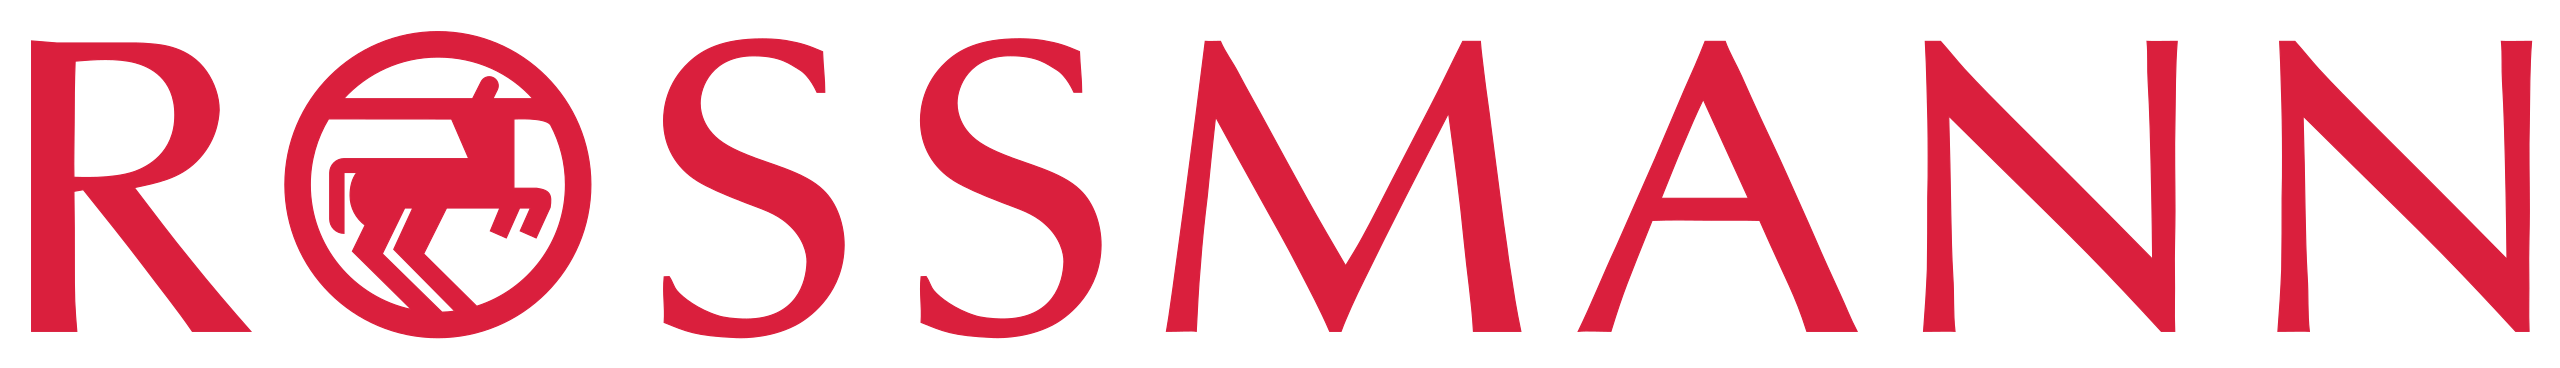

Dirk Rossmann GmbH is one of the largest drug stores chains in Europe, operating over 3000 stores in 7 countries.

Rossmann's CFO recently asked store managers for a projection of the next six weeks of sales, as based on this information, he intends to define the investment that will be made in the renovation of each store. Given the requested information and the lack of accurate response from store managers, the data science team suggested the creation of a sales forecast project for the next 6 weeks to solve this problem and deliver a solution directly to the CFO with all the necessary information and in a way that he could access anywhere and anytime.

For this project, a dataset with sales information for the years 2013 until mid-2015 was made available, with data referring to 1,115 Rossmann stores.

# **IMPORTS**

First, let's import the libraries that we'll need to create the project.

In [95]:
# data manipulation
import math
import inflection
import pandas as pd
import numpy  as np 
from datetime              import date, datetime, timedelta
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
import random

# data visualization
from tabulate            import tabulate
from IPython.display     import Image
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# statistics
import scipy.stats       as ss

# Algorithms
import xgboost as xgb
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso

# ML error metrics 
from sklearn.metrics import mean_absolute_error, mean_squared_error

# save data files
import pickle

## **Helper Functions**

In [99]:
# create Cramér's V function with bias correction - applied in the EDA/Multivariate Analisys/Categorical Attributes
def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
   
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
        
    return np.sqrt( (chi2corr/n) / (min(kcorr-1, rcorr-1)))

# create a function to calculate and return the error of models in a table
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

# create a function to calculate the average percentage error as it is not available in sklearn
def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)

# create a function to calculate the average absolute percentage error as it is not available in sklearn
def mean_absolute_percentage_error(y, yhat):
    return np.mean(abs((y - yhat) / y))

# create a function that applies cross-validation to the data
def cross_validation(x_training, kfold, model_name, model, verbose=False):
    # create the lists where the performances of each iteration of kfold will be saved
    mae_list = []
    mape_list = []
    rmse_list = []
    # create a loop to loop through the number of kfolds and run the training and testing iterations
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        # start date and end date of validation
        validation_start_date = x_training['date'].max() - timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - timedelta(days=(k-1)*6*7)

        # filter the datasets that will be used for training and validation
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training dataset
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']
        # validation dataset
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # train the model
        m = model.fit(xtraining, ytraining)
        # perform prediction
        yhat = m.predict(xvalidation)
        # calculate the error
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        
        # save the performance of each iteration of kfold in a list
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    # return a table with the average of the results for each metric +/- the standard deviation
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                          'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                          'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str) }, index=[0])


## **Loading data**

In [22]:
df_sales_raw = pd.read_csv('C:/Users/victo/repos/Sales_Prediction/data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('C:/Users/victo/repos/Sales_Prediction/data/store.csv', low_memory=False)

# merge to define the main dataset
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# **DATA DESCRIPTION**

In this step we will analyze, clean and pre-process the data for our future analysis.

In [23]:
# set df1 as the main dataset
df1 = df_raw.copy()

## **Rename Columns**

In [24]:
# CamelCase original columns format 
cols_old = df1.columns

# rename columns to snake_case format
df1.columns = list(map(lambda x: inflection.underscore(x), cols_old))

## **Data Dimensions**

In [25]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Cols: {df1.shape[1]}')

Number of Rows: 1017209
Number of Cols: 18


Analyzing the dimensions of the data, it will be possible to carry out the analysis by pandas and without the need for a server.

## **Data Types**

In [26]:
# Change columns 'date' to datetime format
df1['date'] = pd.to_datetime(df1['date'])

## **Check NA**

In [27]:
# checking if there are NAs in the dataset
print(df1.isna().sum())

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64


In [28]:
print('NAs by Store:')

# checking which stores do not have a distance to the nearest competitor
competition_distance_null = list(df_store_raw[df_store_raw['CompetitionDistance'].isnull()]['Store'])
print(f'stores that have no competition_distance: {competition_distance_null}')

# checking how many stores do not have the competition start date
competition_date_null = len(df1[(df1['competition_open_since_month'].isnull()) & (df1['competition_open_since_year'].isnull())]['store'].unique())
print(f'{competition_date_null} stores have no competition_open_since_month & competition_open_since_year')

# verifying how many stores did not join the extended promotion
stores_without_promo2 = len(df1[df1['promo2'] == 0]['store'].unique())
print(f'{stores_without_promo2} stores did not adhere to promo2 (NAs in columns: promo2_since_week & promo2_since_year & promo_interval )')

NAs by Store:
stores that have no competition_distance: [291, 622, 879]
354 stores have no competition_open_since_month & competition_open_since_year
544 stores did not adhere to promo2 (NAs in columns: promo2_since_week & promo2_since_year & promo_interval )


## **Fillout NA**

We can replace the NAs with data obtained through the analysis of the feature's behavior made by ML algorithms, however, for this project we will fill the NAs based on the **assumptions made in view of the understanding of the business**.

In [29]:
# competition_distance (03 stores with NA values)
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 100000 if pd.isna(x) else x)

# competition_open_since_month & competition_open_since_year (354 stores with NA values)
df1['competition_open_since_month'].fillna(1, inplace=True) 
df1['competition_open_since_year'].fillna(2013, inplace=True) 

# promo2_since_week & promo2_since_year (544 stores with NA values)
df1['promo2_since_week'].fillna(0, inplace=True) 
df1['promo2_since_year'].fillna(0, inplace=True)

# promo_interval (544 stores with NA values)
df1['promo_interval'].fillna(0, inplace=True) 

**competition_distance:** 
* **Description**: distance in meters to the nearest competidor store
* **Assumption**: it's NA because there is no competidor close or it is too far away.
* **Realized**: a much greater distance than the maximum was placed, meaning there is no competition

**competition_open_since_month & competition_open_since_year**
* **Description**: approximate year and month of the time the nearest competitor was opened
* **Assumption**: it's NA because there is no competidor close, or existis, but we don't know when it opened (if there is a close competitor, there is a competition start date).
* **Realized**: the month/year of the first sale date of each store was placed inside the column row

**promo2_since_week & promo2_since_year**
* **Description**: year and calendar week when the store started participating in Promo2
* **Assumption**: it's NA because the store decided not to participate in the Promo2, so there is no start date
* **Realized**: a 0 was placed on the row

**promo_interval**
* **Description**: consecutive intervals Promo2 is started
* **Assumption**: it's NA because the store decided not to participate in the Promo2, so there is no interval.
* **Realized**: a 0 was placed on the row

## **Change Types**

In [30]:
# change columns to int format
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64') 
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64') 
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64') 
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64') 

It was identified that the columns **competition_open_since_month, competition_open_since_year, promo2_since_week and promo2_since_year** were not in the correct format, so a change was made to the correct format **int**.

## **Descriptive Statistical**

We will perform descriptive statistics on the data to gain initial business knowledge and identify errors.

In [31]:
# separate data between numeric and categorical
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### **Numerical Attributes**

In [32]:
# central tendency metrics - mean, median
mean   = num_attributes.mean()
median = num_attributes.median()

# dispersion metrics - min, max, range, std, skew, kurtosis
mi      = num_attributes.min()
ma      = num_attributes.max()
rang    = num_attributes.max() - num_attributes.min()
std      = num_attributes.std()
skew     = num_attributes.skew()
kurtosis = num_attributes.kurtosis()

# concat central and dispersion metrics
aux1 = pd.concat([mi, ma, rang, mean, median, std, skew, kurtosis], axis=1).reset_index()
aux1.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
aux1

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908651,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997391,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.926175,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411734,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485759,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,100000.0,99980.0,5675.712376,2330.0,9085.163758,4.637208,35.287543
8,competition_open_since_month,1.0,12.0,11.0,5.244756,4.0,3.928522,0.311511,-1.422995
9,competition_open_since_year,1900.0,2015.0,115.0,2010.060208,2012.0,5.340757,-7.884662,139.910688


**sales & customers** minimum of 0 means the days when stores are closed

**competition_distance** maximum equal to 100k as we replaced the NAs by a distance much greater than the 75860 in the last step.

**promo2_since_week & promo2_since_year**: minimum equal to 0 as we changed the NAs by 0 in the last step.

### **Categorical Attributes**

In [33]:
# check which columns we are going to perform the analysis
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday     4
store_type        4
assortment        3
promo_interval    4
dtype: int64

The analysis will be performed on the columns **state_holiday**, **store_type**, **assortment**.

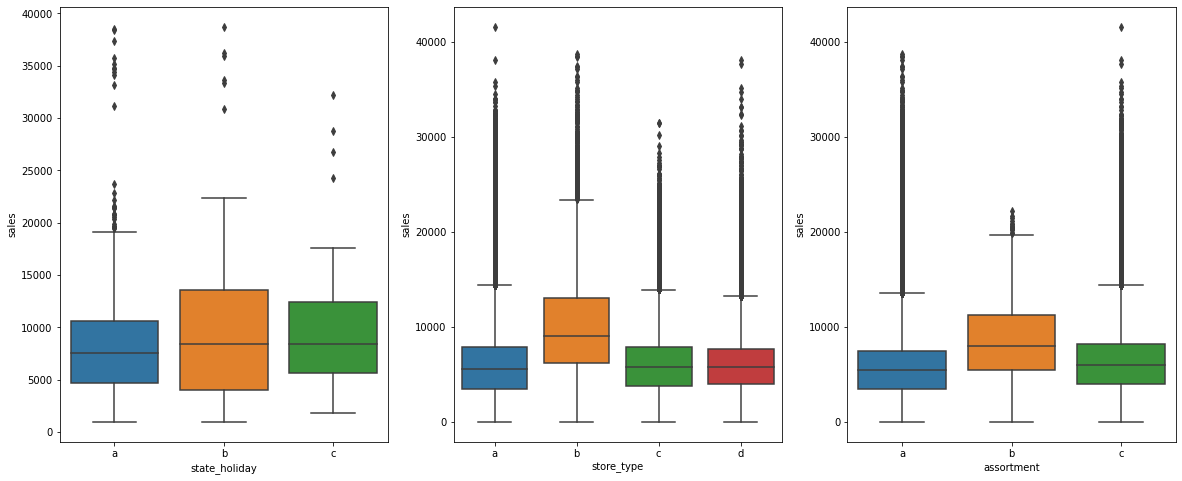

In [34]:
# setting the plot size
plt.rcParams['figure.figsize'] = (20, 8)

plt.subplot(1, 3, 1)
# state_holiday (with dataset filtered by days with sales greater than 0 and which are holidays)
sns.boxplot(x='state_holiday', y='sales', data=df1[(df1['sales'] > 0) & (df1['state_holiday'] != '0')]);

# store_type
plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=df1, order=['a', 'b', 'c', 'd']);

# assortment
plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=df1, order=['a', 'b', 'c']);

**state_holiday:** We observed that type **b** is the one with the largest interquartile range (IQR) between state holidays, however its median does not differ much from type **c**, type **a** is the one with the lowest median and lowest IQR, but still very similar to the other types.

**store_type:** Of the 4 types of stores, the only one that stands out with a median and a higher IQR is type **b**, all other types are below and with measurements very similar.

**assortment:** The store with assortment type **b** has the highest median among the 3, with type **c** being very similar to **a**, but with a slightly higher median.

# **FEATURE ENGINEERING**

In this step, we will raise hypotheses and derive the necessary features to carry out the exploratory data analysis (EDA) in the future.

In [35]:
# copy dataset
df2 = df1.copy()

## **Mind Map Hypothesis**

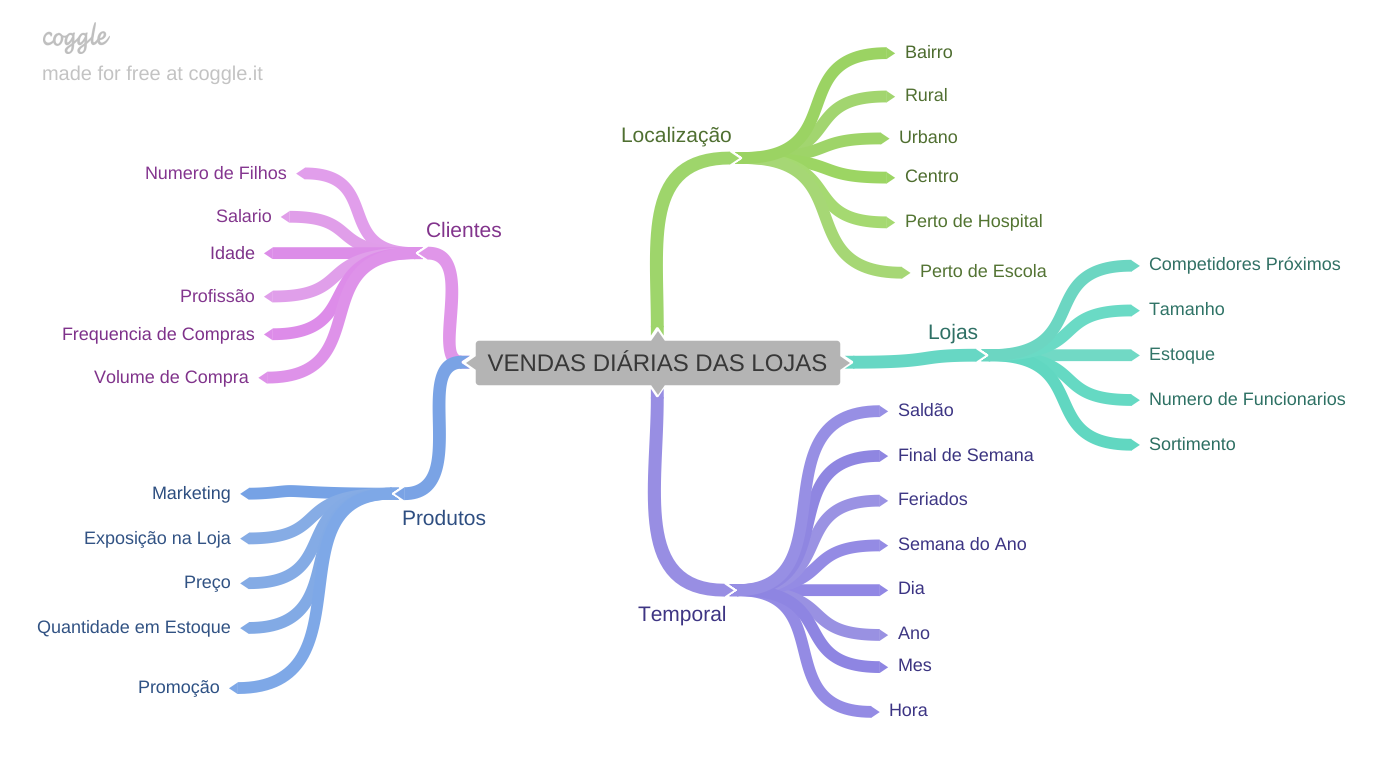

In [36]:
Image('C:/Users/victo/repos/Sales_Prediction/img/MindMapHypothesis.png')

## **Hypothesis Creation**

### **Store Hypothesis**

**1**. Stores with more employees should sell more.

**2**. Stores with more inventory capacity should sell more.

**3**. Larger stores should sell more.

**4**. Stores with larger assortments should sell more.

**5**. Stores with closer competitors should sell less.

**6**. Stores with longer-term competitors should sell more.

### **Product Hypothesis**

**1**. Stores that invest more in Marketing should sell more.

**2**. Stores with greater product exposure should sell more.

**3**. Stores with products at a lower price should sell more.

**5**. Stores with more aggressive promotions (bigger discounts), should sell more.

**6**. Stores with promotions active for longer should sell more.

**7**. Stores with more promotion days should sell more.

**8**. Stores with more consecutive promotions should sell more.

### **Time Hypothesis**

**1**. Stores open during the Christmas holiday should sell more.

**2**. Stores should sell more over the years.

**3**. Stores should sell more in the second half of the year.

**4**. Stores should sell more after the 10th of each month.

**5**. Stores should sell less on weekends.

**6**. Stores should sell less during school holidays.

## **Final List of Hypothesis**

**1**. Stores with larger assortments should sell more.

**2**. Stores with closer competitors should sell less.

**3**. Stores with longer-term competitors should sell more.

**4**. Stores with promotions active for longer should sell more.

**5**. Stores with more promotion days should sell more.

**6**. Stores with more consecutive promotions should sell more.

**7**. Stores open during the Christmas holiday should sell more.

**8**. Stores should sell more over the years.

**9**. Stores should sell more in the second half of the year.

**10**. Stores should sell more after the 10th of each month.

**11**. Stores should sell less on weekends.

**12**. Stores should sell less during school holidays.

## **Feature Engineering**

Based on the hypothesis raised above, we will derive features from the original dataset to perform their validation.

In [37]:
# table with the necessary features for each hypothesis
hip_tab = [['Hypothesis', 'Required Features', 'Features to Create'],
           ['1.Stores with larger assortments should sell more', 'assortment & sales', '-'],
           ['2.Stores with closer competitors should sell less','competition_distance & sales', '-'],
           ['3.Stores with longer-term competitors should sell more', 'time_of_competition & sales', 'time_of_competition'],
           ['4.Stores with promotions active for longer should sell more', 'time_of_promo2 & sales', 'time_of_promo2'],
           ['5.Stores with more promotion days should sell more', 'sum_of_promo_days & sales', 'sum_of_promo_days'],
           ['6.Stores with more consecutive promotions should sell more', 'promo & promo2 & sales', '-'],
           ['7.Stores open during the Christmas holiday should sell more', 'state_holiday & sales', '-'],
           ['8.Stores should sell more over the years', 'year & sales', 'year'],
           ['9.Stores should sell more in the second half of the year', 'month & sales', 'month'],
           ['10.Stores should sell more after the 10th of each month', 'day_of_month x sales', 'day_of_month'],
           ['11.Stores should sell less on weekends', 'day_of_week & sales', '-'],
           ['12.Stores should sell less during school holidays', 'school_holiday & sales', '-']]

print( tabulate(hip_tab, headers='firstrow', tablefmt='fancy_grid'))

╒═════════════════════════════════════════════════════════════╤══════════════════════════════╤══════════════════════╕
│ Hypothesis                                                  │ Required Features            │ Features to Create   │
╞═════════════════════════════════════════════════════════════╪══════════════════════════════╪══════════════════════╡
│ 1.Stores with larger assortments should sell more           │ assortment & sales           │ -                    │
├─────────────────────────────────────────────────────────────┼──────────────────────────────┼──────────────────────┤
│ 2.Stores with closer competitors should sell less           │ competition_distance & sales │ -                    │
├─────────────────────────────────────────────────────────────┼──────────────────────────────┼──────────────────────┤
│ 3.Stores with longer-term competitors should sell more      │ time_of_competition & sales  │ time_of_competition  │
├───────────────────────────────────────────────────────

In [38]:
# day - extract just the sales's day
df2['day'] = df2['date'].dt.day

# month - extract just the sales's month
df2['month'] = df2['date'].dt.month

# year - extract just the sales's year 
df2['year'] = df2['date'].dt.year

# week_of_year - extract the week's number of the year
df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype('int64')

# year_week - extract the year and the week_of_year together
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# is_promo2 - shows if the sale was made during the promo2's interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df2['month_map'] = df2['date'].dt.month.map(month_map)
df2['is_promo2'] = df2[['month_map', 'promo_interval']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

# competition_time_month - time in months since the competition started
df2['competition_since'] = pd.to_datetime(df2['competition_open_since_year'].astype(str) + '-' + df2['competition_open_since_month'].astype(str) + '-1')
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).dt.days

# promo_since - time in weeks since the promotion started
df2['promo2_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str) + '-1'
df2['promo2_since'] = df2['promo2_since'].apply(lambda x: 0 if x == '0-0-1' else (datetime.strptime(x, '%Y-%W-%w')) - timedelta(days=7))
df2['promo2_time_week'] = df2.apply(lambda x: 0 if x['promo2_since'] == 0 else ((x['date'] - x['promo2_since']) / 7).days, axis=1)

# change the letters to the names of the assortment types
df2['assortment'] = df2['assortment'].map({'a': 'basic' , 'b': 'extra', 'c': 'extended'})

# change the letters to the names of state holidays
df2['state_holiday'] = df2['state_holiday'].map({'0': 'regular_day', 'a': 'public_holiday' , 'b': 'easter_holiday', 'c': 'christmas'})

In [39]:
# check data types
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
day                                      int64
month                                    int64
year                                     int64
week_of_year 

# **VARIABLE FILTERING**

In [40]:
# copy dataset
df3 = df2.copy()

## **Line Filtering**

In [41]:
# filter the lines that stores were open and with sales greater than 0
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## **Column Selection**

In [42]:
# remove columns that are no longer relevant and the 'customers' that we won't have access to at the time of the prediction.
cols_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop(cols_drop, axis=1)

# **EXPLORATORY DATA ANALYSIS**

In this step we will explore the data to understand what and how it impacts the phenomenon we are modeling. The main objectives are **gain business experience**, **validate the hypothesis raised** and **identify variables that are important for the model**

In [43]:
# copy dataset
df4 = df3.copy()    

## **Univariate Analysis**

Individual analysis performed to understand the behavior of the variable.

### **Response Variable**

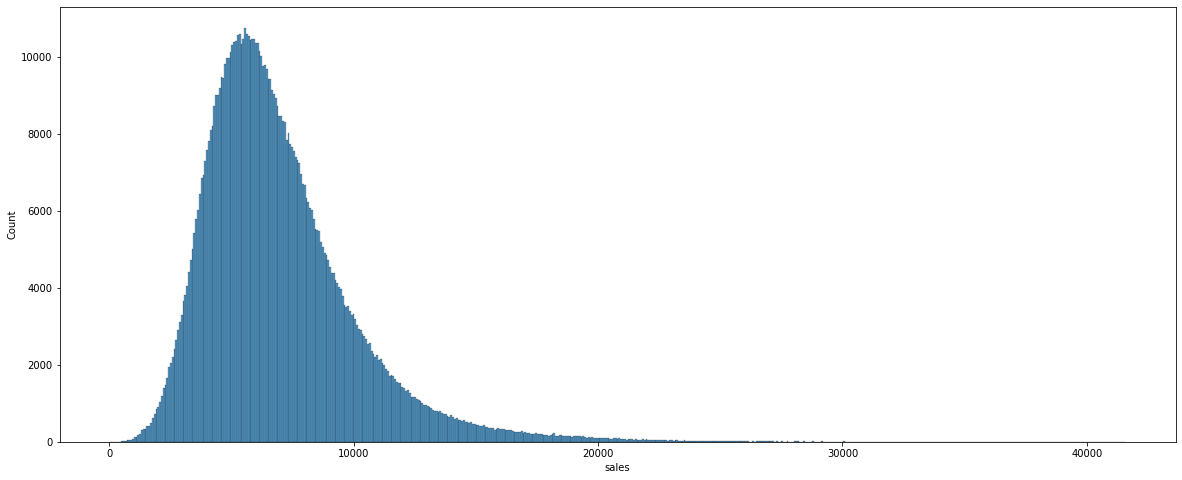

In [44]:
sns.histplot(df4['sales'], kde=False);

**Sales:** Our response variable follows a Poisson distribution and shows us that the average daily sales of Rossmann stores are between 4k and 9k.

### **Numerical Variables**

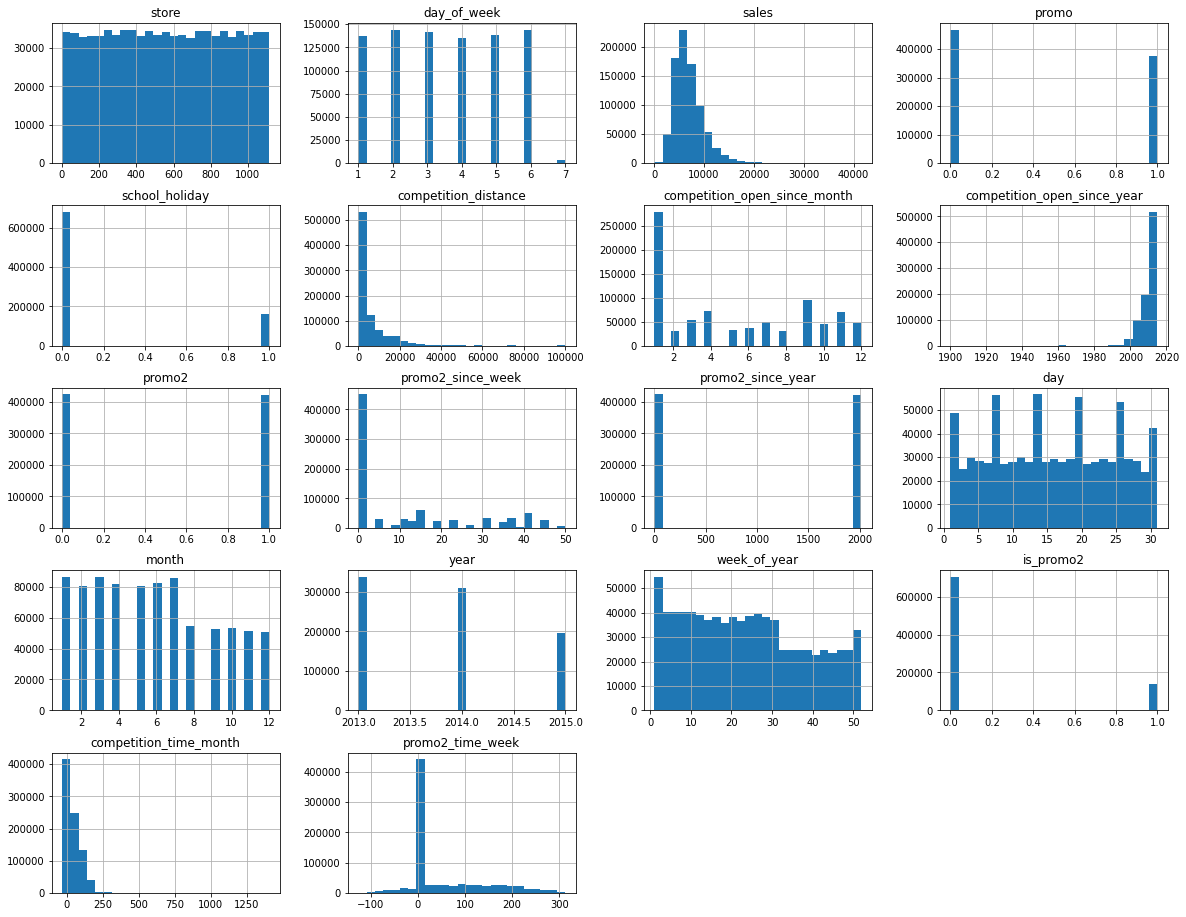

In [45]:
# overwriting the num_attributes with the numeric variables after feature engineering
num_attributes = df4.select_dtypes(include=['int64', 'float'])

num_attributes.hist(bins=25);
plt.gcf().set_size_inches(20,16)

****Some histograms are distorted due to NaN substitution and feature engineering performed before this step. Analyzes were performed on the respective histograms to perform the correct description of the data as shown below:**

**store:** All stores have a similar amount of data in the dataset

**day_of_week:** With the exception of Sundays that most stores are closed, every other day has a very similar amount of appearances in the dataset.

**sales:** Follows a Poisson distribution, where most days sales were made between 4k and 9k.

**promo:** Despite the difference being less than 20%, most days in the dataset refer to days that do not have promotions.

**school_holiday:** The number of days that are not school holidays are significantly greater than the days that are.

**competition distance:** The vast majority of competitors are concentrated near Rossmann stores.

**competition_open_since_month:** There is a curious behavior regarding the opening month of the competitors, with the months of April, September and November being the ones with the most competitors opened.

**competition_open_since_year:** From the 2000s onwards, competitors began to open more significantly, reaching a peak between 2010 and 2015

**promo2:** We have very similar quantities between stores with active promo2 and those that have not joined promo2.

**promo2_since_week:** Most of the stores that joined the promo2 started between the 11th/15th and 35th/40th week of the year.

**promo2_since_year:** Most stores joined promo2 in 2011, followed by 2013 and 2014.

**day:** Every day has a similar amount of appearances in the dataset, with the exception of the 31st which is not present in some months of the year.

**month:** The number of appearances of the months in this dataset are equivalent, except for the month of August onwards, but this is due to the fact that our dataset does not comprise the full year of 2015.

**year:** Dataset comprises 3 years of data, from the highest number of appearances to the lowest: 2013, 2014 and 2015 (not conclusive as it is incomplete)

**week_of_year:** The number of appearances of the weeks of the year in this dataset are equivalent, with the exception of week 32 onwards, but this is because our dataset does not comprise the full year of 2015.

**is_promo2:** Most of the data in this dataset was taken on days when promo2 was not active (+/- 700k data without promo 2 out of a total of 844k)

**competition_time_month:** The vast majority of competitions started in the last 5 years, with the peak being the last year.

**promo2_time_week:** Most stores are participating in promo2 for 40 to 200 weeks.

### **Categorical Variables**

To analyze the categorical variables, we are going to plot and analyze two types of graphs, one that will indicate the **data volume** and the other with its **distributions**.

**State Holiday**

╒══════════════════╤══════════════╤═════════════════╕
│ State Holidays   │   Total Days │   Sales Average │
╞══════════════════╪══════════════╪═════════════════╡
│ Public Holidays  │           25 │         8487.47 │
├──────────────────┼──────────────┼─────────────────┤
│ Easter Holiday   │            6 │         9887.89 │
├──────────────────┼──────────────┼─────────────────┤
│ Christmas        │            4 │         9743.75 │
╘══════════════════╧══════════════╧═════════════════╛


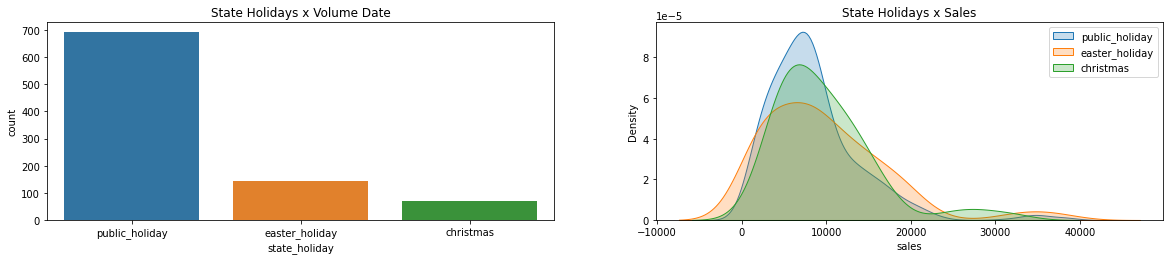

In [46]:
# create a table with state holidays, total days and average sales
tab = [['State Holidays', 'Total Days', 'Sales Average'],
       ['Public Holidays', df4[df4['state_holiday'] == 'public_holiday']['date'].unique().shape[0], df4[df4['state_holiday'] == 'public_holiday']['sales'].mean()],
       ['Easter Holiday', df4[df4['state_holiday'] == 'easter_holiday']['date'].unique().shape[0], df4[df4['state_holiday'] == 'easter_holiday']['sales'].mean()],
       ['Christmas', df4[df4['state_holiday'] == 'christmas']['date'].unique().shape[0], df4[df4['state_holiday'] == 'christmas']['sales'].mean()]]

print(tabulate(tab, headers='firstrow', tablefmt='fancy_grid'))

# plot the volume of days for each state holiday
plt.subplot(2, 2, 1)
sns.countplot(x= df4[df4['state_holiday'] != 'regular_day']['state_holiday']).set_title('State Holidays x Volume Date');

# plot the distribution of each state holiday against sales
plt.subplot(2, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], shade=True).set_title('State Holidays x Sales') ;
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], shade=True);
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], shade=True);
plt.legend(['public_holiday', 'easter_holiday', 'christmas']);

**State Holiday:** As expected, **public holidays(25)** add up to the highest number of appearances in the dataset, followed by **easter(6)** and **Christmas(4)**, but it is important to remember that Christmas appears less than Easter because the dataset does not include the entire year of 2015. Analyzing the distributions of each type in relation to sales , we conclude that all are positively asymmetric, the **public holidays** have more concentrated sales, followed by **Christmas and Easter** which have a greater positive asymmetry. The average sales for **Easter and Christmas** are 9.8 and 9.7k, which is higher than the average of 8.5k for **public holidays**.

**It is important to note that Easter and Good Friday holidays are identified as "easter_holiday" in the dataset, and that in Europe some countries do not consider these dates as public holidays, which impacts trade. From the total of 1,115 Rossmann stores featured in the dataset, only 32 opened on that date.

**Store Type**

╒══════════════╤════════════════════╤═════════════════╕
│ Store Type   │   Number of Stores │   Sales Average │
╞══════════════╪════════════════════╪═════════════════╡
│ A            │                602 │         6925.7  │
├──────────────┼────────────────────┼─────────────────┤
│ B            │                 17 │        10233.4  │
├──────────────┼────────────────────┼─────────────────┤
│ C            │                148 │         6933.13 │
├──────────────┼────────────────────┼─────────────────┤
│ D            │                348 │         6822.3  │
╘══════════════╧════════════════════╧═════════════════╛


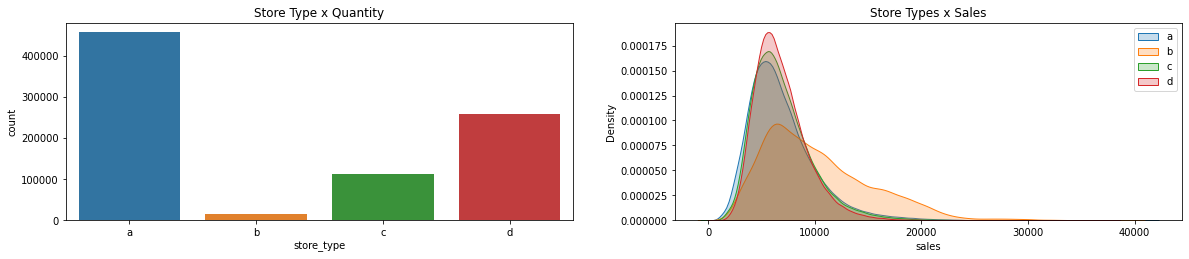

In [47]:
# create a table with the types of stores, number of stores, average sales
tab = [['Store Type', 'Number of Stores', 'Sales Average'],
       ['A', df4[df4['store_type'] == 'a']['store'].unique().shape[0], df4[df4['store_type'] == 'a']['sales'].mean()],
       ['B', df4[df4['store_type'] == 'b']['store'].unique().shape[0], df4[df4['store_type'] == 'b']['sales'].mean()],
       ['C', df4[df4['store_type'] == 'c']['store'].unique().shape[0], df4[df4['store_type'] == 'c']['sales'].mean()],
       ['D', df4[df4['store_type'] == 'd']['store'].unique().shape[0], df4[df4['store_type'] == 'd']['sales'].mean()]]

print(tabulate(tab, headers='firstrow', tablefmt='fancy_grid'))

# plot the volume of data for each type of store
plt.subplot(2, 2, 1)
sns.countplot(x= df4['store_type'], order=['a', 'b', 'c', 'd']).set_title('Store Type x Quantity' );


# plot the distribution of each type of store in relation to sales
plt.subplot(2, 2, 2)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], shade=True).set_title('Store Types x Sales');
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], shade=True);
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], shade=True);
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], shade=True);
plt.legend(['a', 'b', 'c', 'd']);

**Store Type:** The type **a** with 602 units represents more than 50% of total stores, followed by **d** with 348 stores, **c** with 148 stores and finally **b** with 17 stores. Analyzing the distributions of each type in relation to sales, we conclude that they are all positively asymmetric, with types **a, c, d** being very similar, with concentrated data (positive kurtosis) and with average sales between 6.5/7k, while the type **b**, despite being the type with the smallest amount of stores, is the one with a much more positive distribution, with an average daily sales of 10k.

**Assortment**

╒═══════════════════╤═══════════════════╤═════════════════╕
│ Assortment Type   │   Number of Store │   Sales Average │
╞═══════════════════╪═══════════════════╪═════════════════╡
│ Basic             │               593 │         6621.52 │
├───────────────────┼───────────────────┼─────────────────┤
│ Extra             │                 9 │         8642.5  │
├───────────────────┼───────────────────┼─────────────────┤
│ Extended          │               513 │         7300.84 │
╘═══════════════════╧═══════════════════╧═════════════════╛


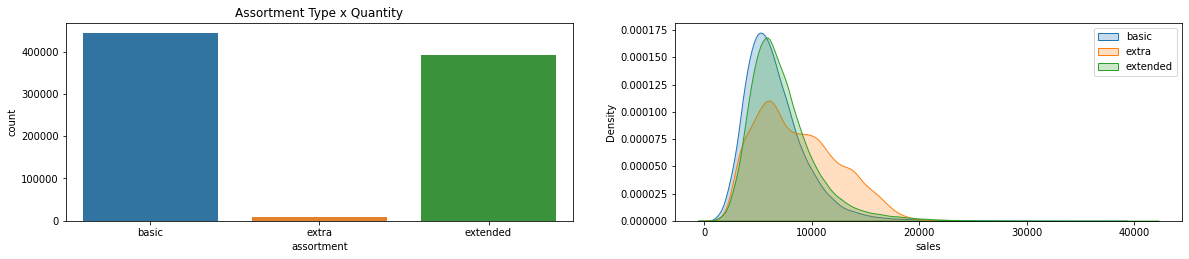

In [48]:
# create a table with the type of assortment, number of stores and average sales
tab = [['Assortment Type', 'Number of Store', 'Sales Average'],
       ['Basic', df4[df4['assortment'] == 'basic']['store'].unique().shape[0], df4[df4['assortment'] == 'basic']['sales'].mean()],
       ['Extra', df4[df4['assortment'] == 'extra']['store'].unique().shape[0], df4[df4['assortment'] == 'extra']['sales'].mean()],
       ['Extended', df4[df4['assortment'] == 'extended']['store'].unique().shape[0], df4[df4['assortment'] == 'extended']['sales'].mean()]]
print(tabulate(tab, headers='firstrow', tablefmt='fancy_grid'))

# plot the volume of data for each type of store
plt.subplot(2, 2, 1)
sns.countplot(x= df4['assortment'], order=['basic', 'extra', 'extended']).set_title('Assortment Type x Quantity');

# plot the distribution of each type of store in relation to sales
plt.subplot(2, 2, 2)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], shade=True);
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], shade=True);
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], shade=True);
plt.legend(['basic', 'extra', 'extended']);

**Assortment:** The **basic** type with 593 units represents more than 50% of the total number of stores, closely followed by the **extended** with 513 stores and then the **extra** with only 9 stores. Analyzing the distributions of each type in relation to sales, we conclude that they are all positively skewed, however the types **basic** and **extended** have a grater positive kurtosis, which means high concentration of values. The **extra** type, on the other hand, despite being a minority in the number of stores, has a greater positive asymmetry, which indicates that the average sales of this type of store is higher than the others. Which makes us wonder why we have so few stores with that kind of assortment.

## **Bivariate Analysis**

Analysis of one or more variables in relation to sales to identify how they impact the response variable. In this step we will answer the business hypothesis raised in the Feature Engineering step.

### **H1**. Stores with larger assortments should sell more.

**FALSE** Greater assortment does not necessarily mean more sales.

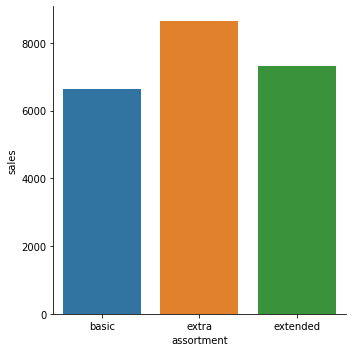

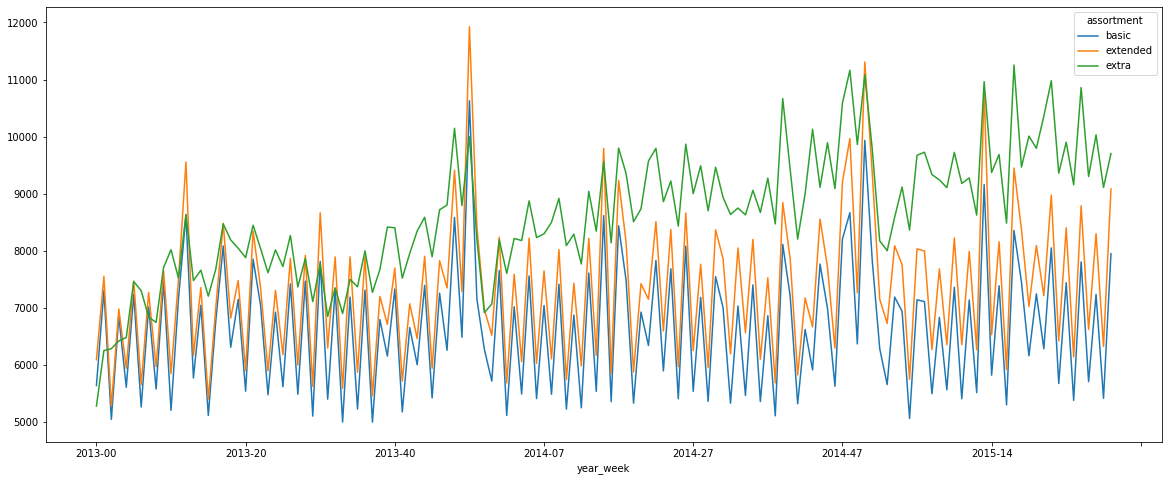

In [49]:
# plot average sales by assortment
aux1 = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()
sns.catplot(x='assortment', y='sales', kind='bar', data=aux1, order=['basic', 'extra', 'extended']);

# pivot sales data for assortment types over time to display historical behavior
aux2 = df4[['assortment', 'sales', 'year_week']].groupby(['year_week', 'assortment']).mean().reset_index( )
aux2.pivot(index='year_week', columns='assortment', values='sales').plot();

**Analysis:** We see a significant increase in sales from **basic** to **extra**, however, sales decrease from **extra** for **extended**, but still getting bigger than **basic**. Analyzing the sales behavior, we were able to observe that the types **basic and extended** are very similar in terms of sales behavior, with a small difference in volume. The type **extra** has a different behavior, which indicates that this type of store does not follow the pattern of the other two.

We can then conclude that even if there is an initial increase, it is not maintained in the other types, which leads us to **refute the hypothesis**.

**Importance for the Model:** Mean

### **H2**. Stores with closer competitors should sell less.

**FALSE** There is no significant difference in relation to the distance from the nearest competitor, some stores even sell more with these competitors.

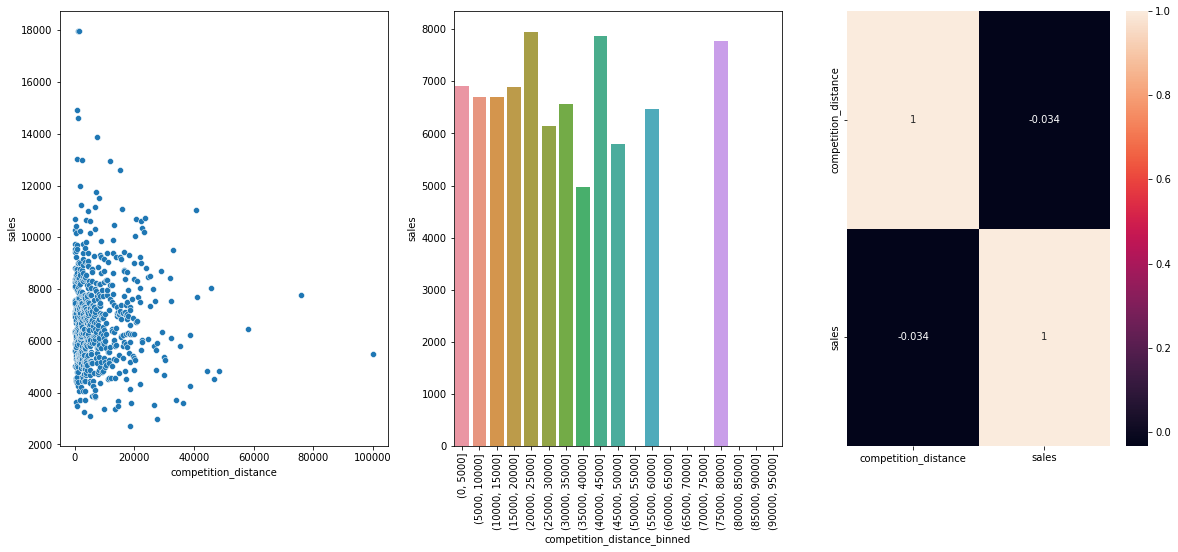

In [50]:
# create an auxiliary dataframe with sales grouped by distance from nearest competitor
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index()

# plot a scatter plot to analyze the relationship between distance from competition and sales
plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

# plot a bar graph with the distance from the competition grouped together to analyze sales
plt.subplot(1,3,2)
bins = list(np.arange(0, 100000, 5000)) # Need to create bins to decrease data granularity
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').mean().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90);

# plot the correlation between both variables
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

**Analysis:** As seen in graphs 1 and 2, sales made by stores with closer competitors (mostly) are very similar to stores with more distant competitors, in fact, some stores with closer competitors have a average sales even higher. Analyzing the Pearson correlation, which is almost null, we can conclude that both variables are not correlated.

**Importance for the Model:** Low

### **H3**. Stores with longer-term competitors should sell more.

**FALSE** Stores with longer-term competitors sell LESS.

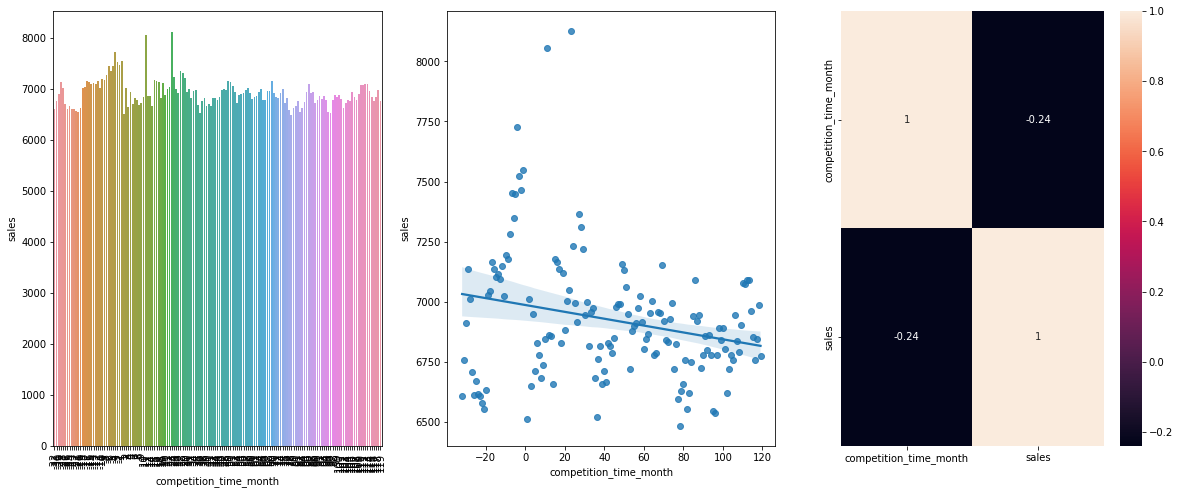

In [51]:
# create an auxiliary dataframe with sales grouped by competition time and filtered to be between 0 and 120 months
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').mean().reset_index()
aux1 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]

# plot a bar graph to view average sales per month
plt.subplot(1, 3, 1)
sns.barplot(x='competition_time_month', y='sales', data=aux1);
plt.xticks(rotation=90);

# plot a linear regression graph to see if there is a trend between the variables
plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux1);

# plot the correlation between both variables
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

**Analysis:** There is a weak inverse relationship between competition time and sales, that is, the longer the competition time, the smaller the sales tend to be. What is also noteworthy is that the closer to the opening date of a competitor, the more sales the store makes. Analyzing the Pearson correlation which is -24, we can conclude that both variables are inversely correlated at a low level.

**Importance for the Model:** Average

### **H4**. Stores with promotions active for longer should sell more.

**TRUE** Stores with promotions active for longer actually sell more.

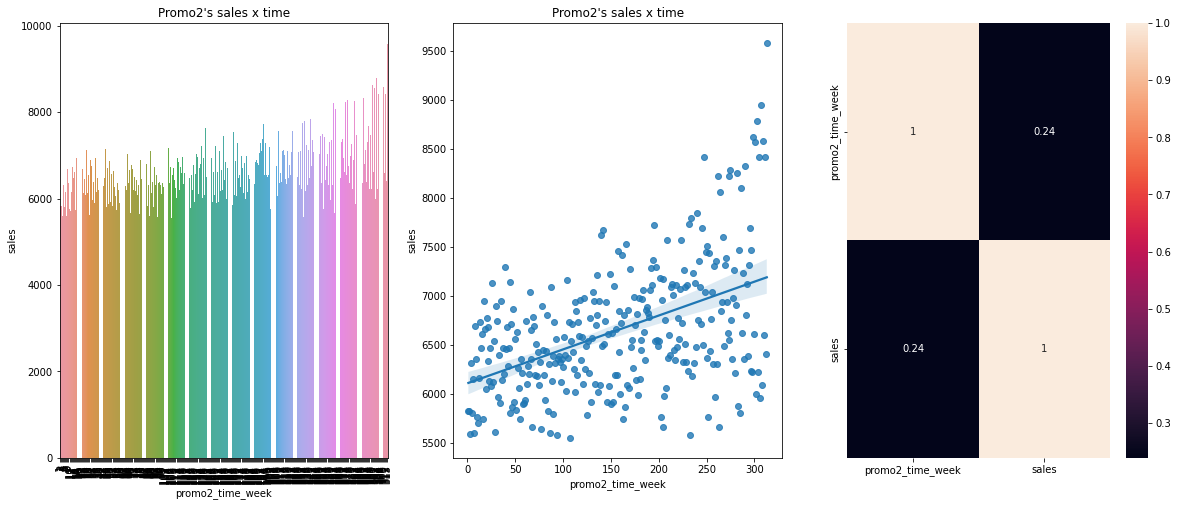

In [52]:
# Create an auxiliary sales dataframe grouped by promos2's time and filter only data greater than 0 weeks
aux1 = df4[['promo2_time_week', 'sales']].groupby('promo2_time_week').mean().reset_index()
aux2 = aux1[aux1['promo2_time_week'] > 0]

grid = GridSpec(1, 3)

# plot a bar graph to analyze sales behavior in relation to promo2's time
plt.subplot(grid[0,0])
sns.barplot(x='promo2_time_week', y='sales', data=aux2).set_title("Promo2's sales x time");
plt.xticks(rotation=90)

# plot a linear regression graph to see if there is a trend between the variables
plt.subplot(grid[0,1])
sns.regplot(x='promo2_time_week', y='sales', data=aux2).set_title("Promo2's sales x time");

# plot the correlation between both variables
plt.subplot(grid[0,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

****aux2:** A filter was carried out on the number of weeks of promo2 above 0, as stores that joined promo2 after having made sales, returned negative values regarding the difference between the two dates , which does not provide any useful information for the validation of this hypothesis.

**Analysis:** There is a **positive** relationship between the time of participation in the promo2 and the average sales, that is, the longer the time (measured by weeks) of participation in the promo2, the higher the average sales made by the stores. To confirm our analysis, we performed the Pearson correlation test, which confirms a weak positive relationship of 0.24.

**-** A possible justification would be that customers get used to promotions and increase the recurrence of purchases over time, as they are loyal. 

**Importance for the Model:** Average


### <s>**5**. Stores with more promotion days should sell more.</s>
**Analyze in the second cycle of CRISP.**

### **H6**. Stores with more consecutive promotions should sell more.

**FALSE** Stores with more consecutive promotions (promo2 active) sell less.

In [53]:
# display the different combinations between normal and extended promotion and analyze your average sales
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).mean().reset_index()

,promo,promo2,sales
0,0,0,6328.187633
1,0,1,5529.566684
2,1,0,8618.452062
3,1,1,7836.672987


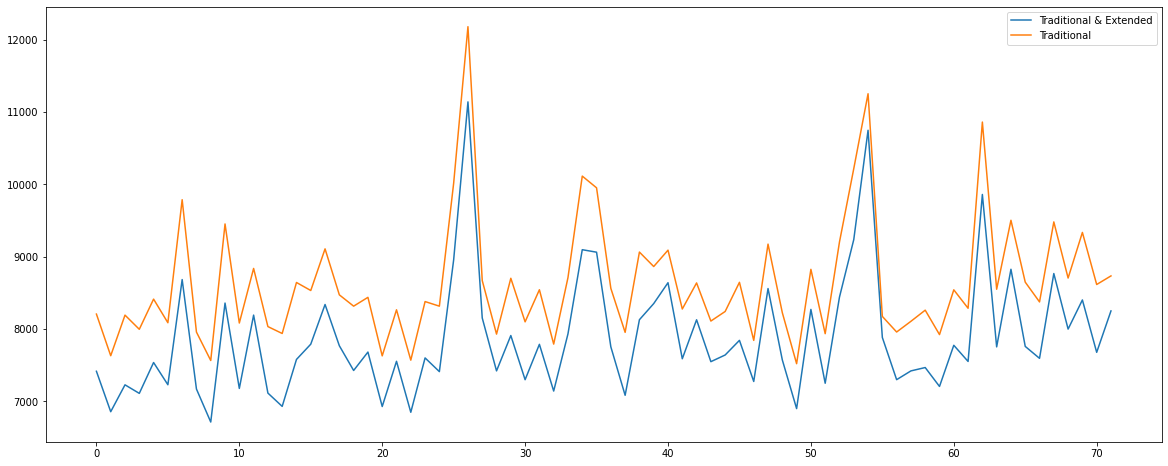

In [54]:
# plot sales behavior over time, when there is only traditional promotion
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').mean().reset_index()
ax = aux1.plot()

# plot sales behavior over time, when there is traditional and extended promotion
aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').mean().reset_index()
aux2.plot( ax = ax );

ax.legend(labels = ['Traditional & Extended', 'Traditional']);

**Analysis:** There is a very similar sales behavior between the **traditional** and **traditional + extended** promotions, however, the average sales of the stores who opted only for traditional promotions are greater in relation to others. This makes us wonder if it makes sense to keep promo2 active in stores.

**Importance for the Model:** Average

### **H7**. Stores open during the Christmas holiday should sell more.

**TRUE** Stores open during the Christmas holiday sell more.

Christmas's average sales is 40.12% higher than normal days


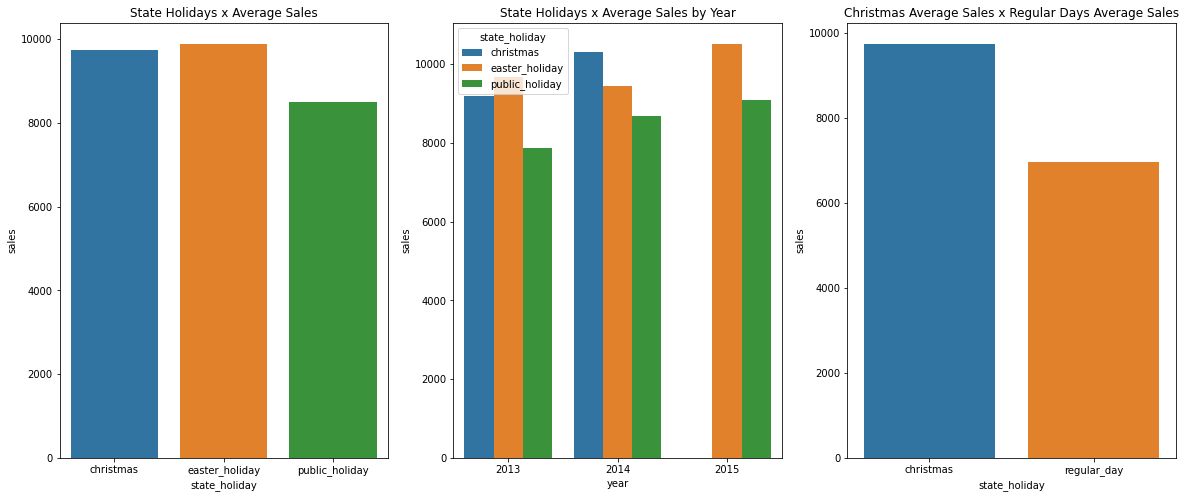

In [55]:
# create an auxiliary dataframe for state holidays without regular days
aux1 = df4[df4['state_holiday'] != 'regular_day']
# create an auxiliary dataframe only for Christmas and regular days to perform the comparison
aux2 = df4[(df4['state_holiday'] == 'christmas') | (df4['state_holiday'] == 'regular_day')]

# plot a bar graph with the average total sales by type of state holiday
plt.subplot(1, 3, 1)
aux3 = aux1[['state_holiday', 'sales']].groupby('state_holiday').mean().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux3).set_title('State Holidays x Average Sales');

# plot a bar graph with average annual sales by type of state holiday
plt.subplot(1, 3, 2)
aux4 = aux1[['state_holiday', 'sales', 'year']].groupby(['state_holiday', 'year']).mean().reset_index( )
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux4).set_title('State Holidays x Average Sales by Year');

# plot a bar graph with the average total sales for Christmas compared to the average total sales for normal days
plt.subplot(1, 3, 3)
aux5 = aux2[['state_holiday', 'sales']].groupby('state_holiday').mean().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux5).set_title('Christmas Average Sales x Regular Days Average Sales');
print(f"Christmas's average sales is {(aux5['sales'][0] / aux5['sales'][1] - 1) * 100:.2f}% higher than normal days")

**Analysis:** Checking the average sales of the 3 types of state holidays, we noticed that **Christmas** and **Easter** have a very similar average , being superior to public holidays. However, because our dataset does not have the full year of 2015 (not including Christmas) we will analyze it by year (graph 2), and from it we can conclude that in the years **2013 and 2014** the average of Christmas sales was higher compared to other holidays, which leads us to believe that due to this pattern, 2015 will be no different.

Looking now at Graph 3, we see a 40% increase in Christmas sales compared to normal days, which is very considerable.

Given the information presented, let's confirm our hypothesis as being **true**.

**Importance for the Model:** Average

### **H8**. Stores should sell more over the years.

**TRUE** From 2013 to 2014 there was an increase of 3.1%; from 2014 to 2015 there has been an increase so far (open) of 0.9%.

The evolution in average sales from 2013 to 2014 is 3.1%
The evolution in average sales from 2013 to 2014 is 0.9%


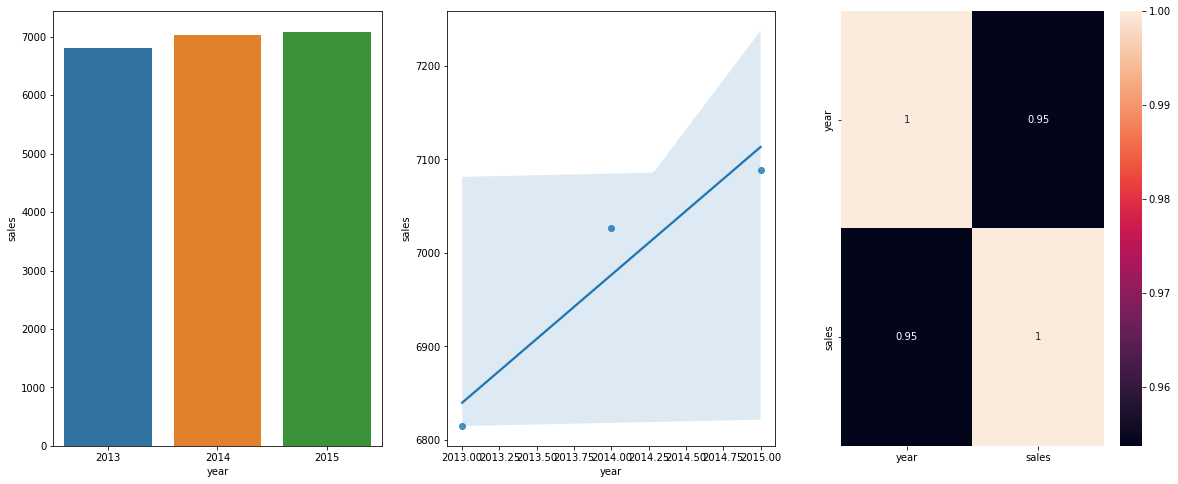

In [56]:
# create an auxiliary dataframe with the average sales per year
aux1 = df4[['year', 'sales']].groupby('year').mean().reset_index()

# plot a bar graph with average sales per year
plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1);

# plot a linear regression graph to see if there is a trend between the passing of years and sales
plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1);

# plot the correlation between both variables
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

# Display the percentage difference between the average sales between years
print(f'The evolution in average sales from 2013 to 2014 is {(aux1["sales"][1] / aux1["sales"][0] - 1) *100:.1f}%' )
print(f'The evolution in average sales from 2013 to 2014 is {(aux1["sales"][2] / aux1["sales"][1] - 1)* 100:.1f}%' )

**Analysis:** Analyzing the results of the plotted graphs, we can conclude that the stores increase their average sales over the years, but it is a very moderate increase, being around **3.1% between 2013-2014** and **0.9% between 2014-2015 (to date).** Also analyzing the Pearson correlation between the variables, we arrived at 0.95, which means that they are extremely correlated.

******It is important to emphasize that the year of 2015 is not yet complete, however as we are analyzing the average sales, let's consider the hypothesis as being **true**.

**Importance for the Model:** High

### **H9**. Stores should sell more in the second half of the year.

**TRUE** Stores sell more in the second half of the year, with a significant increase in December.

2013: 1st: 6707.53 2nd: 6929.67 - The second half of 2013 has an average sales 3.31% higher than the first semester.
2014: 1st: 6905.33 2nd: 7199.37 - The second half of 2014 has an average sales 4.26% higher than the first semester.
The average sales for the month of December is 27.07% higher than the average for all other months combined.


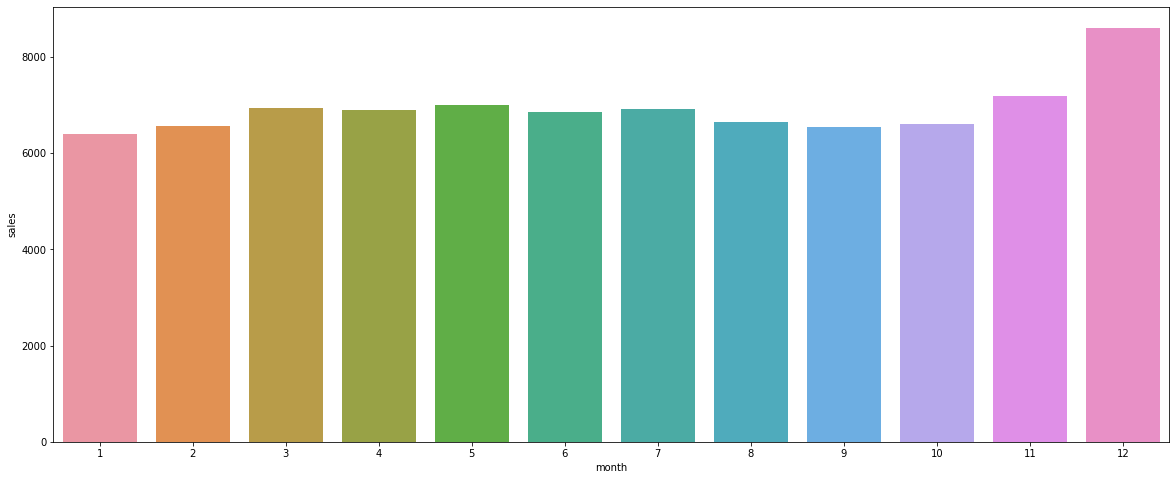

In [57]:
# create an auxiliary dataframe with the average sales per week of the year
aux = df4[['year_week', 'sales']].groupby('year_week').mean().reset_index()

# Display average sales for the first and second half of 2013 and their percentage difference
a = aux[aux['year_week'] <= '2013-26']['sales'].mean()
b = aux[(aux['year_week'] >= '2013-27') & (aux['year_week'] <= '2013-52')]['sales']. mean()
print(f'2013: 1st: {a:.2f} 2nd: {b:.2f} - The second half of 2013 has an average sales {(b / a -1) *100:.2f}% higher than the first semester.')

# Display average sales for the first and second half of 2014 and its percentage difference
c = aux[(aux['year_week'] >= '2014-00') & (aux['year_week'] <= '2014-26')]['sales'].mean()
d = aux[(aux['year_week'] >= '2014-27') & (aux['year_week'] <= '2014-52')]['sales'].mean()
print(f'2014: 1st: {c:.2f} 2nd: {d:.2f} - The second half of 2014 has an average sales {(d / c -1)* 100:.2f}% higher than the first semester.')

# plot a bar graph with the total average sales per month without considering the year 2015 that is open
aux2 = df4[df4['year'] != 2015][['month', 'sales']].groupby('month').mean().reset_index()
sns.barplot(x='month', y='sales', data = aux2);

# display the percentage difference between average December sales versus average sales for all other months together
e = (aux2['sales'][11] / aux2[aux2['month'] <= 11]['sales'].mean() - 1) * 100
print(f"The average sales for the month of December is {e:.2f}% higher than the average for all other months combined.")

******We will not use the year 2015 in this analysis because it is open.

**Analysis:** In both years 2013 and 2014, the **second semester was the one with the highest average sales**, being **+3.31% in 2013** and **+4.26% in 2014**. Analyzing the average sales for each month of the year (2013 and 2014 together), we observe that sales show a slight increase between the months of March to July, while in November the average starts to increase taking its peak to December, the month it obtains an average of sales **27.07 higher** than the average of all other previous months combined.

**Importance for the Model:** High

### **H10**. Stores should sell more after the 10th of each month.

**FALSE** On average, stores sell 7% more in the first 10 days of each month.

Average sales for the first 10 days of the months: 7307.76
Average sales for the 11th to 31st of the months: 6824.77
Percentage that the average of the first 10 days is higher: 7.08


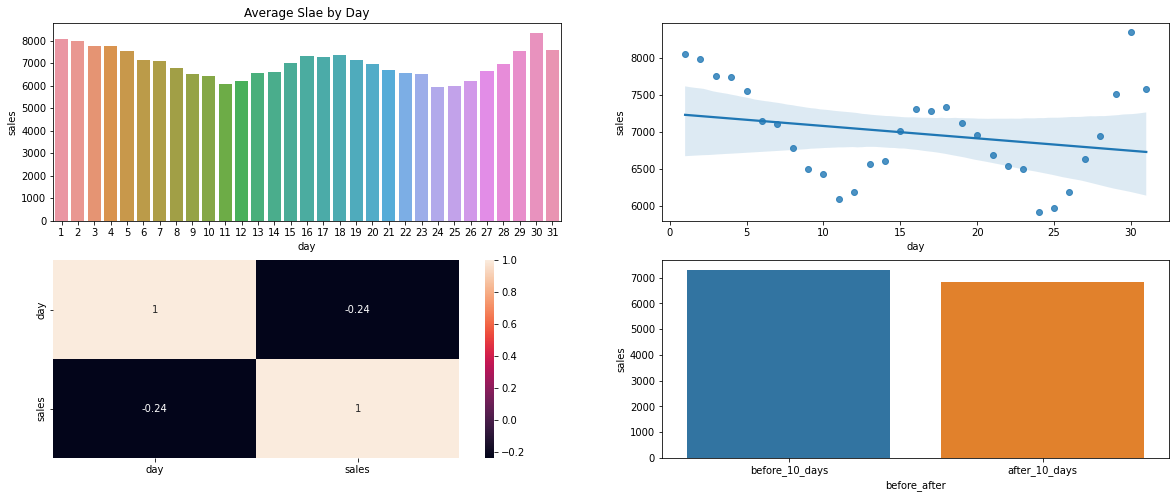

In [58]:
# create an auxiliary dataset with the average sales per day of the month
aux1 = df4[['day', 'sales']].groupby('day').mean().reset_index()

# create an auxiliary dataset with sales averages before the 10th and after it
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 = aux1[['before_after', 'sales']].groupby('before_after').mean().reset_index()

# plot a bar graph with the average total sales per day of the month
plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1).set_title('Average Slae by Day');

# plot a linear regression graph to see if there is a trend between the day of the month and sales
plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1);

# plot the correlation between the days of the month and the average sales for each day
plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

# plot a bar chart with the average sales before the 10th and above it
plt.subplot(2, 2, 4)
sns.barplot( x='before_after', y='sales', data=aux2, order=['before_10_days', 'after_10_days']);

# display the results and the percentage difference between them
print(f"Average sales for the first 10 days of the months: {aux1[(aux1['day'] >= 1) & (aux1['day'] <= 10)]['sales'].mean() :.2f}")
print(f"Average sales for the 11th to 31st of the months: {aux1[(aux1['day'] >= 11) & (aux1['day'] <= 31)]['sales'].mean( ):.2f}")
print(f'Percentage that the average of the first 10 days is higher: {(7307.76 / 6824.77 - 1) * 100:.2f}')

**Analysis:** Average sales per day follow a curious pattern, rising and falling throughout the month, falling between a range of 6K and 8K. According to this pattern, the best sales days are between the **1st and 5th**, **15th and 20th** and **27th and 31st**, it would be interesting to conduct further research into the cause of this variation to better understand this phenomenon.

On the average summed between the days, the stores **sell +7% in the first 10 days** of the month in relation to the rest, which leads us to refute the hypothesis.

**Importance for the Model:** High

### **H11**. Stores should sell less on weekends.

**TRUE** Stores sell less on weekends

Difference of weekday x weekend average sales: -1.74.


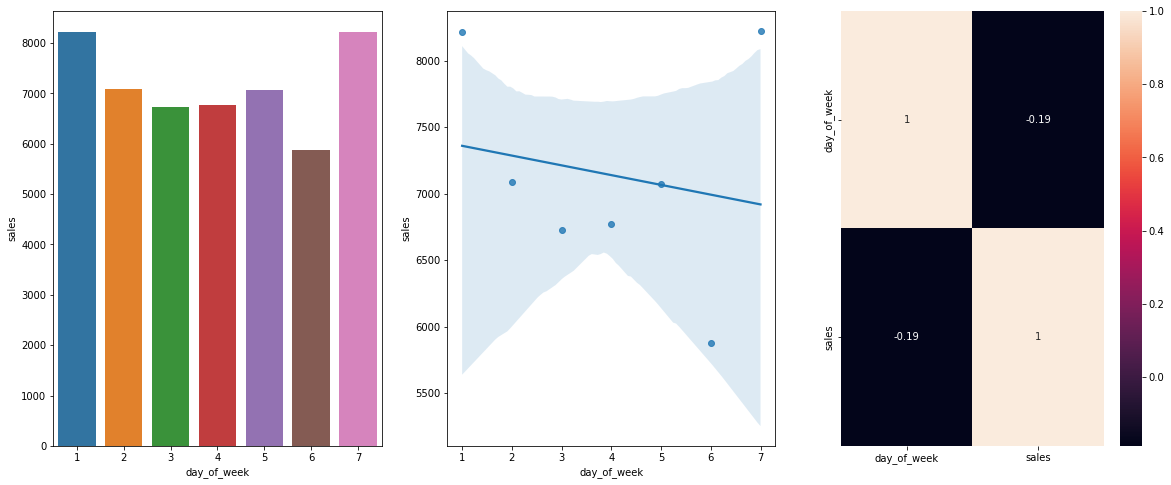

In [59]:
# create an auxiliary dataset with the average total sales per weekday
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').mean().reset_index()

# display the percentage difference between the average of weekday x weekend sales
print(f"Difference of weekday x weekend average sales: {(aux1[aux1['day_of_week'] > 5]['sales'].mean() / aux1 [aux1['day_of_week'] <= 5]['sales'].mean() - 1) * 100:.2f}.")

# plot a bar chart with the average total sales by day of the week
plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

# plot a linear regression graph to see if there is a trend between the day of the week and sales
plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

# plot the correlation between both variables
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

**Analysis:** Analyzing by the average sales of each day of the week, we can observe that there is an inverse relationship between sales and days, that is, **the average sales decreases according to the week passes by**. Although Sunday has an average sales higher than others, the number of stores that are open on these days are extremely low, and even comparing the average sales on the weekend with the days of the week, the **average Weekend sales is 1.74% lower than the average week sales**.

Given the information raised in the analysis, let's validate the hypothesis.

**Importance for the Model:** Average

### **H12**. Stores should sell less during school holidays.

**FALSE** Stores sell an average of 4.4% more on school holidays.

Average sales on school holidays is 4.40% higher than normal days. 


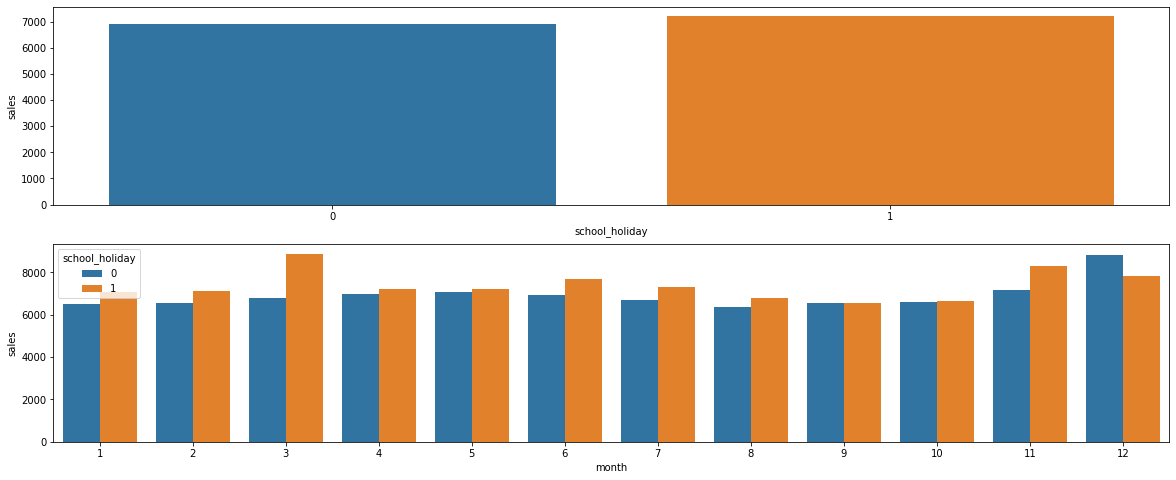

In [60]:
# create an auxiliary dataframe with the average sales of days that have and do not have school holidays
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').mean().reset_index()

# plot a bar graph with the average sales on days that are and are not school holidays
plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

# display the percentage difference between days with and without school holidays
print(f"Average sales on school holidays is {(aux1['sales'][1] / aux1['sales'][0] - 1) * 100:.2f}% higher than normal days. ")

# create an auxiliary dataframe with the average monthly sales for days that have and do not have school holidays
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).mean().reset_index( )

# plot a bar graph with the average monthly sales for days you have and not school holidays
plt.subplot(2, 1, 2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

**Analysis:** Analyzing the plotted graphs we were able to observe that the average sales of days that are **school holidays is 4.4% higher** compared to normal days and that by analyzing the split graph across the months we can see December as the only month in which normal days have a higher average sales compared to days with school holidays.

**Importance for the Model:** Average

### **Summary of Hyphotesis**

In [61]:
# create a table with the conclusion of the analysis and the observed relevance to the model
tab = [['Hypothesis', 'Conclusion', 'Relevance'],
       ['H01', 'False', 'Average'],
       ['H02', 'False', 'Low'],
       ['H03', 'False', 'Average'],
       ['H04', 'True', 'Average'],
       ['H05', '-', '-'],
       ['H06', 'False', 'Low'],
       ['H07', 'True', 'Average'],
       ['H08', 'True', 'High'],
       ['H09', 'True', 'High'],
       ['H10', 'False', 'High'],
       ['H11', 'True', 'Average'],
       ['H12', 'False', 'Average']]

print(tabulate(tab, headers='firstrow'))

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H01           False         Average
H02           False         Low
H03           False         Average
H04           True          Average
H05           -             -
H06           False         Low
H07           True          Average
H08           True          High
H09           True          High
H10           False         High
H11           True          Average
H12           False         Average


## **Multivariate Analysis**

Analysis of all variables together to identify the correlation and how they relate to each other.

### **Numerical Attributes**

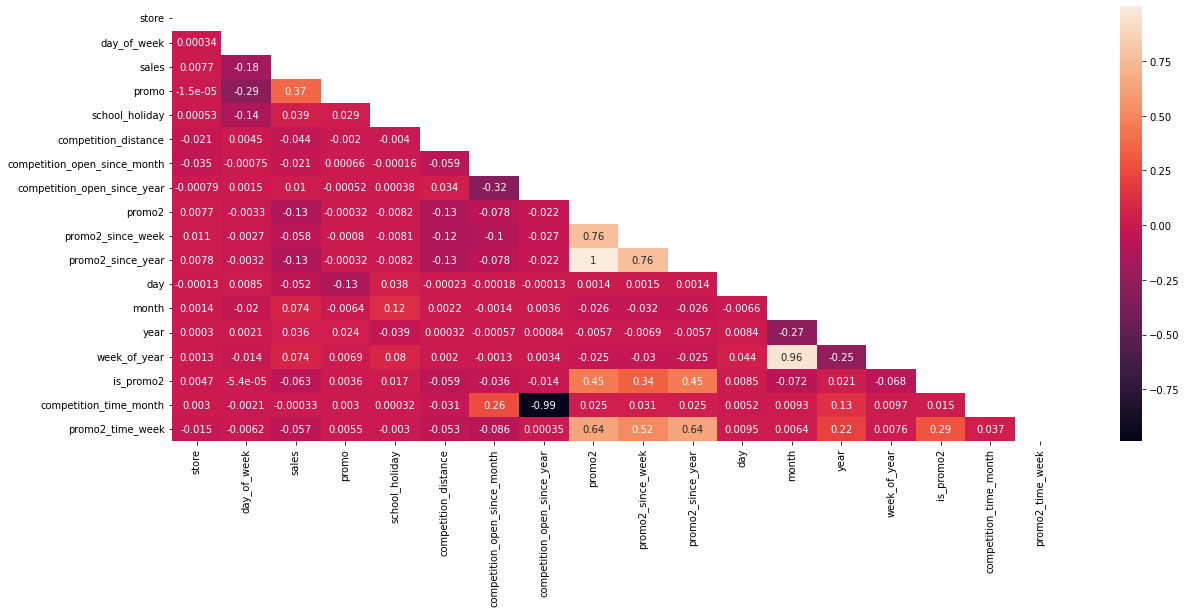

In [62]:
# create a correlation matrix and apply a mask to not show the mirror
correlation = num_attributes.corr(method='pearson')
mask = np.triu(correlation)

# plot the correlation with the mask
sns.heatmap(correlation, annot=True, mask=mask);

**Positive Correlations**
*   ( 1 ) Promo2 Since Year x Promo2
*   (.96) Week of Year x Month
*   (.76) Promo2 Since Week x Promo2
*   (.76) Promo2 Since Year x Promo2 Since Week
*   (.64) Promo2 Time Week x Promo2
*   (.64) Promo2 Time Week x Promo2 Since Year
*   (.45) Is Promo2 x Promo2
*   (.45) Is Promo2 x Promo2 Since Year
*   (.29) Promo2 Time Week x Is Promo2
*   (.26) Competition Time Month x Competition Open Since Month
*   (.22) Promo2 Time Week x Year
*   (.13) Competition Time Month x Year
*   (.12) Month x School Holiday

**Positive Correlations with Sales**
*   (.37) Sales x Promo 
*   (.07) Sales x Month 
*   (.07) Sales x Week of Year

**Negative Correlations**
*   (-.99) Competition Time Month x Competition Open Since Year
*   (-.32) Competition Open Since Year x Competition Open Since Month
*   (-.29) Promo x Day of Week
*   (-.27) Year x Month
*   (-.14) School Holiday x Day of Week
*   (-.13) Day x Promo
*   (-.13) Promo2 x Competition Distance
*   (-.13) Promo2 Since Year x Competition Distance
*   (-.12) Promo2 Since Week x Competition Distance
*   (-.1 ) Week of Year x Year

**Negative Correlations with Sales**
*   (-.18) Sales x Day of Week
*   (-.13) Sales x Promo2
*   (-.13) Sales x Promo2 Since Year


### **Categorical Attributes**

In [63]:
## only categorical data
#a = df4.select_dtypes(include='object')

## calculate cramer v
#a1 = cramer_v(a['state_holiday'], a['state_holiday'])
#a2 = cramer_v(a['state_holiday'], a['store_type'])
#a3 = cramer_v(a['state_holiday'], a['assortment'])

#a4 = cramer_v(a['store_type'], a['state_holiday'])
#a5 = cramer_v(a['store_type'], a['store_type'])
#a6 = cramer_v(a['store_type'], a['assortment'])

#a7 = cramer_v(a['assortment'], a['state_holiday'])
#a8 = cramer_v(a['assortment'], a['store_type'])
#a9 = cramer_v(a['assortment'], a['assortment'])

## final dataset
#d = pd.DataFrame({'state_holiday': [a1, a2, a3],
#                  'store_type':    [a4, a5, a6],
#                  'assortment':    [a7, a8, a9]})
#d = d.set_index(d.columns)

#sns.heatmap(d, annot=True);

# **DATA PREPARATION**

In this step we will model the data to apply the Machine Learning algorithms in the next steps.

In [64]:
# copy dataset
df5 = df4.copy()

In [65]:
# select the columns that will need to make the changes
df5.select_dtypes(include=['int64', 'float64']).head()
df5.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]']).head()

tab = [['Rescaling:', 'competition_distance, year, competition_time_month, promo2_time_week'],
       ['Natural Transformation:', 'day_of_week, day, month, week_of_year'],
       ['Encoding:', 'state_holiday, store_type, assortment']]

print(tabulate(tab))

-----------------------  --------------------------------------------------------------------
Rescaling:               competition_distance, year, competition_time_month, promo2_time_week
Natural Transformation:  day_of_week, day, month, week_of_year
Encoding:                state_holiday, store_type, assortment
-----------------------  --------------------------------------------------------------------


*The other features (with the exception of sales) we will not make any changes because it is not necessary or because we have already extracted the relevant information for other features in the feature engineering step.

## **Normalization**

Data normalization is applied to numerical variables, preferably that have a Gaussian distribution and aims to change the column values ​​to a common scale (center being 0 and std equal to 1) without changing the nature of their distribution, preventing the algorithm is biased towards values ​​with a higher order of magnitude. ***We won't need to apply this technique to any variable in our dataset.**

## **Rescaling**


Rescaling is applied to numerical variables, preferably that do not have a normal distribution and aims to change the column values ​​to a common scale (between 0 and 1) without changing the nature of its distribution, preventing the algorithm from being biased towards values ​​with higher order of magnitude.

In [66]:
# instantiate the class and save it to a variable
rs = RobustScaler() # variables with significant outliers
mms = MinMaxScaler() # variables without significant outliers

# apply the robust scaler in competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# apply robust scaler in competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# apply minmax scaler on promo time week
df5['promo2_time_week'] = mms.fit_transform(df5[['promo2_time_week']].values)

# apply the minmax scaler to the year variable
df5['year'] = mms.fit_transform(df5[['year']].values)

**competition_distance**: applied to Robust Scaler because we insert outliers when replacing NAs(maximum distance 100k)

**competition_time_month**: applied to Robust Scaler because variable presented outliers (competition time greater than 1400 months, when the normal is around 100).

**promo2_time_week** & **year**: applied MinMax Scaler because they did not have outliers.

## **Transformation**

The transformation is applied when there is a need to make some kind of change in the variable to make it possible, or better, to facilitate the understanding of the variable by the ML model.

### **Encoding**

Let's transform our categorical variables into numeric variables keeping the information content, for that we'll apply some encoding techniques.

In [67]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

**state_holiday:** Applied One Hot Encoding because the content of the feature is a state and changes the behavior of other features, in front of that this technique facilitates learning for this type of data.

**store_type:** Applied Label Encoding as we don't have information that the content of this feature follows a certain order, appearing to be distinct types, so let's just change it by a reference number.

**assortment:** Ordinal Encoding is applied as the feature content follows an order from smallest to largest assortment.

### **Response Variable Transformation**

Let's log our response variable to change its skew and approximate it as closely as possible to a normal distribution.

In [68]:
# apply log to adjust distribution
df5['sales'] = np.log1p(df5['sales'])

### **Nature Transformation**

Let's carry out the nature transformation in some variables of our dataset, in order to bring the real (cyclic) nature of the data, which in this case are dates.

In [69]:
# extract the sine and cosine of the variable day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# extract the sine and cosine from the variable month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# extract the sine and cosine of the day of week variable
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

# extract the sine and cosine of the week of year variable
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

**day:** We extract the sine and cosine of the variable day so the data better represent the cycle of +/-31 days per month.

**month:** We extract the sine and cosine of the month variable so the data better represent the 12-month-per-year cycle.

**day_of_week:** We extract the sine and cosine of the day-of-week variable so the data better represent the 7-day-a-week cycle.

**week_of_year:** We extract the sine and cosine of the week-of-year variable so the data better represent the 52-week-per-year cycle.

# **FEATURE SELECTION**

In this stage of the project, we will select the most important features for learning the model through the Boruta algorithm.

In [70]:
# copy dataset
df6 = df5.copy()

## **Split dataframe into training and test dataset**

In [71]:
# remove original variables that served as a basis for deriving other variables
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo2_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [72]:
# training dataset - all except the last 6 weeks of the dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# teste dataset - last 6 weeks of dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date {}'.format(X_train['date'].min()))
print('Training Max Date {}'.format(X_train['date'].max()))

print('\nTest Min Date {}'.format(X_test['date'].min()))
print('Test Max Date {}'.format(X_test['date'].max()))

Training Min Date 2013-01-01 00:00:00
Training Max Date 2015-06-18 00:00:00

Test Min Date 2015-06-19 00:00:00
Test Max Date 2015-07-31 00:00:00


## **Boruta as Feature Selector**

In [73]:
# # training and test dataset for boruta (remove date and sales)
# X_train_n = X_train.drop(['date', 'sales'], axis=1).values
# y_train_n = y_train.values.ravel()

# # set RandomForestRegressor
# rf = RandomForestRegressor(n_jobs=-1)

# # define Boruta as feature selector, using random forest with the number of trees automatically defined
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

A training array was created for boruta without sales data and date, which is differentiated by the fact that it needs to be an array and not a dataframe, so we used the **.values**, and the ravel to turn this into a vector

Let's use random forest in boruta because...

We define the boruta with the random forest choosing the number of trees automatically and with random_state=42 for all the trees to start from the same point.

**BorutaPy finished running.**

**Iteration: 9 / 100,
Confirmed: 17,
Tentative: 0,
Rejected: 10**

### **Best Features from Boruta**

In [74]:
# # check which columns the boruta selected and its relevance
# cols_selected = boruta.support_.tolist()

# # display selected column names instead of index
# X_train_fs = X_train.drop(['date',  'sales'], axis=1)
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# # check which columns boruta did not select
# cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

### **Manual Feature Selection**

In [75]:
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo2_time_week',
                        'day_sin',
                        'day_cos',
                        'month_sin',
                        'month_cos',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'week_of_year_sin',
                        'week_of_year_cos']

# columns to return to dataset
feat_to_add = ['date', 'sales'] 
 
# final dataset 
# cols_selected_boruta.extend(feat_to_add)
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add )

Although boruta hasn't identified the **month_cos** and **week_of_year_cos** as important, we're going to add it so that both variables have the sine and cosine for the best representation of the its cyclical nature.

We return the column **date** and **sales** to the dataset because we are still going to use them to train the model and do the cross-validation.

# **MACHINE LEARNING MODELLING**

In this step we will choose some Machine Learning algorithms that we believe can get good results and apply on the modeled data.

In [76]:
# Define the training and test with the variables selected by boruta
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]

## **Average Model**

We use the average model to be a comparative basis for the performance of other Machine Learning models.

In [77]:
# create an auxiliary dataset with test data + sales (average based on ú)
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# create a second auxiliary dataset with sales averages grouped by stores (predictions) and overwrite the result in the 'sales' column
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})

# merge the two auxiliary datasets to check the error later
aux3 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux3['predictions']

# apply the error calculation function created to measure performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## **Linear Regression Model**

We use linear models (which are simpler),
to measure the complexity of the phenomenon we are working on, if it is low, the model will get a good performance and we will be able to use it as the main one.

In [78]:
# instantiate the model and insert training data for the model to learn
lr = LinearRegression().fit(x_train, y_train)

# apply the test data for it to perform the prediction
yhat_lr = lr.predict(x_test)

# apply the error calculation function created to measure performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1872.423595,0.296045,2663.610818


Checking the result we were able to conclude that the **average model has a better performance than linear regression** which shows us that our data has a complex behavior, being necessary to apply more sophisticated models to better understand this phenomenon.

#### **Linear Regression Model - Cross Validation**

In [84]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2101.23 +/- 305.87,0.31 +/- 0.02,2966.91 +/- 495.48


After applying cross-validation in Linear Regression, we were able to analyze that the **result with cross-validation had worse results** than the prediction of the test dataset, which shows us that the data from the last 6 weeks that we set aside for testing had a more normal behavior in relation to the rest of the dataset and this would give us a wrong perception of the result of the algorithm.

## **Linear Regression Regularized Model - Lasso**

Lasso regularized linear regression (L1) follows the same concept as simple linear regression, but it is a more useful technique when the data is a little more complex and we want to improve the model's accuracy. It does this by balancing the model's fit to the data and reducing the magnitude of the coefficients to 0 (attributing no importance).

In [85]:
# instantiate the model and insert training data for the model to learn
lrr = Lasso(alpha=0.00001).fit(x_train, y_train)

# apply the test data for it to perform the prediction
yhat_lrr = lrr.predict(x_test)

# apply the error calculation function created to measure performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1872.441593,0.295978,2663.938443


Lasso's **alpha** parameter is responsible for multiplying all values ​​and, based on the result, increasing or decreasing the weights to restrict them within a range, improving the model's fit to the data.

We can verify that even using the Lasso **the result is still bad in relation to the average**, which means that our phenomenon is not simple, being necessary more sophisticated algorithms to obtain better results.

### **Lasso - Cross Validation**

In [86]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

C:\Users\victo\repos\Sales_Prediction\salesprediction\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2486.1196588018647, tolerance: 11.17220426551362
  model = cd_fast.enet_coordinate_descent(
C:\Users\victo\repos\Sales_Prediction\salesprediction\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 597.5115905502316, tolerance: 11.937395279075513
  model = cd_fast.enet_coordinate_descent(


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2101.19 +/- 306.09,0.31 +/- 0.02,2967.1 +/- 495.69


The Cross-Validation of the Lasso Linear Regression presented the same result as the previous Linear Regression, obtaining worse results with the Cross-Validation, confirming the bias of the algorithm in relation to the test data.

## **Random Forest Regressor**

Because the results of the linear models were not satisfactory, we understand that our phenomenon is complex, which leads us to implement a little more sophisticated algorithms such as Random Forest Regressor.

In [87]:
# # instantiate the model and insert training data for the model to learn
# rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# # apply the test data for it to perform the prediction
# yhat_rf = rf.predict(x_test)

# # apply the error calculation function created to measure performance
# rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
# rf_result

### **Random Forest Regressor - Cross Validation**

In [88]:
# rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
# rf_result_cv

Following the results of the other algorithms, Random Forest Regressor also showed a worse result with Cross-Validation, confirming the bias of the algorithm in relation to the test data.

## **XGBoost Regressor**

Because the results of the linear models were not good, we understand that our phenomenon is complex, which leads us to implement a little more sophisticated algorithms like XGBoost Regressor.

In [89]:
# # instantiate the model and insert training data for the model to learn
# model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                              n_estimators=100,
#                              eta=0.01,
#                              max_depht=10,
#                              subsample=0.7,
#                              colsample_bytree=0.9).fit(x_train, y_train)

# # apply the test data for it to perform the prediction
# yhat_xgb = model_xgb.predict(x_test)

# # apply the error calculation function created to measure performance
# xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
# xgb_result

### **XGBoost Regressor - Cross Validation**

In [90]:
# xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
# xgb_result_cv

Following the results of the other algorithms, XFBoost Regressor also showed a worse result with Cross-Validation, confirming the bias of the algorithm in relation to the test data.

## **Compare Model's Performance**

### **Single Performance**

In [91]:
# # create a table to display results
# modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
# modelling_result.sort_values('RMSE')

# create a table to display the results
tab = [['Model Name',                'MAE',         'MAPE',     'RMSE'],
       ['Random Forest Regressor',   '667.565276',  '0.098677', '992.484702'], 
       ['Average Model',             '1354.800353',	'0.455051',	'1835.135542'],
       ['XGBoost Regressor',         '1698.959041', '0.253773', '2452.285024'],
       ['Linear Regression',         '1872.423595', '0.296045', '2663.610818'],
       ['Linear Regression - Lasso', '1872.441593',	'0.295978',	'2663.938443']]
       
print(tabulate(tab, headers='firstrow'))

Model Name                      MAE      MAPE      RMSE
-------------------------  --------  --------  --------
Random Forest Regressor     667.565  0.098677   992.485
Average Model              1354.8    0.455051  1835.14
XGBoost Regressor          1698.96   0.253773  2452.29
Linear Regression          1872.42   0.296045  2663.61
Linear Regression - Lasso  1872.44   0.295978  2663.94


We can analyze through the generated results that the **best performance was from Random Forest**, being far ahead of the other models, which confirms the complexity of the data. However, we cannot conclude that the random forest obtained the best result until **we carry out the cross-validation** and analyze how the algorithm behaves with different validation data.

It is also important to emphasize that the parameters used were the default ones, because in the **fine tuning step we will find the best parameters for the chosen model**.

### **Real Performance - Cross Validation**

In this stage of the project we will apply a Cross-Validation method where we will divide the training dataset into several parts, separate new training/validation data respecting the chronological order of the data and apply the algorithms multiple times in different parts of the dataset to reach the actual result of the models.

In [92]:
# # create a table to display results
#modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
#modelling_result_cv.sort_values('RMSE CV')

# create a table to display the results
RP_CV = [['Model Name',              'MAE CV',             'MAPE CV',        'RMSE CV'],
         ['Random Forest Regressor', '838.0 +/- 243.63',   '0.12 +/- 0.03',  '1255.13 +/- 360.36'],
         ['XGBoost Regressor',       '1849.7 +/- 224.01',  '0.26 +/- 0.01', '2654.74 +/- 325.59'],
         ['Linear Regression',       '2101.23 +/- 305.87', '0.31 +/- 0.02',  '2966.91 +/- 495.48'],
         ['Lasso',                   '2122.47 +/- 367.94', '0.29 +/- 0.01',  '3047.73 +/- 550.3']]

print(tabulate(RP_CV, headers='firstrow', tablefmt='fancy_grid'))

╒═════════════════════════╤════════════════════╤═══════════════╤════════════════════╕
│ Model Name              │ MAE CV             │ MAPE CV       │ RMSE CV            │
╞═════════════════════════╪════════════════════╪═══════════════╪════════════════════╡
│ Random Forest Regressor │ 838.0 +/- 243.63   │ 0.12 +/- 0.03 │ 1255.13 +/- 360.36 │
├─────────────────────────┼────────────────────┼───────────────┼────────────────────┤
│ XGBoost Regressor       │ 1849.7 +/- 224.01  │ 0.26 +/- 0.01 │ 2654.74 +/- 325.59 │
├─────────────────────────┼────────────────────┼───────────────┼────────────────────┤
│ Linear Regression       │ 2101.23 +/- 305.87 │ 0.31 +/- 0.02 │ 2966.91 +/- 495.48 │
├─────────────────────────┼────────────────────┼───────────────┼────────────────────┤
│ Lasso                   │ 2122.47 +/- 367.94 │ 0.29 +/- 0.01 │ 3047.73 +/- 550.3  │
╘═════════════════════════╧════════════════════╧═══════════════╧════════════════════╛


After analyzing the results of the algorithms with Cross-Validation, we can conclude that **all had inferior results in relation to performance related to the test data**, which showed us that the set of separate data for testing (last 6 weeks) presented more well-behaved data, which biased the performance of the models. However, even with a decrease in errors, **Random Forest obtained a significant result**, being ahead of the other models.

******It is important to emphasize that there can be a very significant improvement in the performance of the models after the **fine tuning step** and that because this **project is part of the Data Science in Production course and the purpose of carrying it out is the composition of the project portfolio and the development of skills in the area, I will continue this first phase of CRISP with XGBoost Regressor**, which obtained the second best result after cross-validation.

# **HYPERPARAMETER FINE TUNING**

In this step, we will carry out a process to find the set of parameters that maximize the learning of the chosen model, with the objective of obtaining better results, which in this project means reducing the error.

## **Random Search**

We have some techniques for choosing the best hyperparameters for the model, each with its advantages and disadvantages. In this **first CRISP cycle**, we will use Random Search, which randomly defines the values ​​of each of the hyperparameters and performs several iterations in order to obtain the best set of parameters among those tested. The advantage of using this technique is the speed in relation to the others, and the disadvantage is that as the definition is random, it may happen that we do not find the best parameter for the model.

In [ ]:
# # define the range of parameters for random search to test
# param = {
#     'n_estimators': [1500, 1700, 2500, 3000, 3500],
#     'eta': [0.01, 0.03],
#     'max_depht': [3, 5, 9],
#     'subsample': [0.1, 0.5, 0.7],
#     'colsample_bytree': [0.3, 0.7, 0.9],
#     'min_child_weight': [3, 8, 15]
#     }
# 
# # define the number of iterations random search will perform
# MAX_EVAL = 5

In [ ]:
# # define the table where the results will be displayed
# final_result = pd.DataFrame()
# 
# # create a loop to test values randomly
# for i in range(MAX_EVAL):
#    # choose parameter values randomly
#    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#    print(hp)
# 
#    # train the model with the chosen values
#    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                                 n_estimators=hp['n_estimators'],
#                                 eta=hp['eta'],
#                                 max_depht=hp['max_depht'],
#                                 subsample=hp['subsample'],
#                                 colsample_bytree=hp['colsample_bytree'],
#                                 min_child_weight=hp['min_child_weight'])
# 
#    # display the model result with cross validation
#    result = cross_validation(x_training, 2, 'XGBoost Regressor', model_xgb, verbose=False)
#    final_result = pd.concat([final_result, result])
# final_result

In [93]:
tab_result = [['Model Name', 'MAE CV', 'MAPE CV', 'RMSE CV'],
              ['XGBoost Regressor', '1057.12 +/- 51.3', '0.14 +/- 0.0', '1523.33 +/- 103.03']]

print(tabulate(tab_result, headers='firstrow', tablefmt='fancy_grid'))

╒═══════════════════╤══════════════════╤══════════════╤════════════════════╕
│ Model Name        │ MAE CV           │ MAPE CV      │ RMSE CV            │
╞═══════════════════╪══════════════════╪══════════════╪════════════════════╡
│ XGBoost Regressor │ 1057.12 +/- 51.3 │ 0.14 +/- 0.0 │ 1523.33 +/- 103.03 │
╘═══════════════════╧══════════════════╧══════════════╧════════════════════╛


Como podemos analisar, a **X iteração** foi a que apresentou o melhor conjunto de parâmetros.

## **Final Model**

Final result of the Machine Learning algorithm applied in the project.

In [ ]:
# # insert the tuned parameters
# param_tuned = {
#     'n_estimators': 3000,
#     'eta': 0.03,
#     'max_depht': 5,
#     'subsample': 0.7,
#     'colsample_bytree': 0.7,
#     'min_child_weight': 3
#     }

In [ ]:
# # train the model with the tuned parameters
# model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
#                                   n_estimators=param_tuned['n_estimators'],
#                                   eta=param_tuned['eta'],
#                                   max_depht=param_tuned['max_depht'],
#                                   subsample=param_tuned['subsample'],
#                                   colsample_bytree=param_tuned['colsample_bytree'],
#                                   min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train  )
# 
# # perform prediction
# yhat_xgb_tuned = model_xgb_tuned.predict(x_test)
# 
# # check performance
# xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
# xgb_result_tuned

In [ ]:
# # save the trained model in a pickle file so it doesn't need to run again
# pickle.dump(model_xgb_tuned, open('C:/Users/victo/repos/Sales_Prediction/model/model_rossmann.pkl', 'wb'))
# 
# # save the model prediction in a pickle file so it doesn't need to run again
# pickle.dump(yhat_xgb_tuned, open('C:/Users/victo/repos/Sales_Prediction/model/model_prediction.pkl', 'wb'))

In [97]:
# load model predictions stored in pickle so it doesn't need to run again
yhat_xgb_tuned = pickle.load(open('C:/Users/victo/repos/Sales_Prediction/model/model_prediction.pkl', 'rb'))

In [102]:
# # calculate the mpe of the result
mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))

-0.02439001319188599

The negative MPE error shows us that the model is overestimating sales, that is, at each prediction the predicted value tends to be greater than the real value.

In [101]:
# create a table with the final result of the model
tab_xgb_result_tuned = [['Model Name',          'MAE',        'MAPE',      'RMSE',       'MPE'],
                        ['XGBoost Regressor', '813.985678', '0.123916', '1157.718851', '-0.02439001319578856']]
print(tabulate(tab_xgb_result_tuned, headers='firstrow'))

Model Name             MAE      MAPE     RMSE       MPE
-----------------  -------  --------  -------  --------
XGBoost Regressor  813.986  0.123916  1157.72  -0.02439


# TRANSLATION AND INTERPRETATION OF THE ERROR

In this stage of the project, we are going to translate the result of the machine learning model into a business result, so that we can better measure the impact on the company and facilitate the communication of results to the business team.

In [103]:
# copy the necessary data
df9 = X_test[cols_selected_boruta_full]

In [104]:
# return the sales and predictions data that were applied in the log to the original scale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

C:\Users\victo\AppData\Local\Temp/ipykernel_107852/3572907419.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1(df9['sales'])
C:\Users\victo\AppData\Local\Temp/ipykernel_107852/3572907419.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions'] = np.expm1(yhat_xgb_tuned)


## **Business Performance**

In [105]:
# add the predictions to know how much revenue will come in according to the model
df9_predict_by_store = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# calculate MAE and MAPE of predictions for each store
df9_mae = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
df9_mape = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAPE'})

# merge the store data with the MAE and MAPE
df9_mae_mape = pd.merge(df9_mae, df9_mape, how='inner', on='store')
df9_final = pd.merge(df9_predict_by_store, df9_mae_mape, how='inner', on='store')

# create the best and worst scenario of the predictions made
df9_final['worst_scenario'] = df9_final['predictions'] - (df9_final['predictions'] * df9_final['MAPE'])
df9_final['best_scenario'] = df9_final['predictions'] + (df9_final['predictions'] * df9_final['MAPE'])

# sort columns
df9_final = df9_final[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [106]:
# show the stores with the biggest errors
df9_final.sort_values('MAPE', ascending=False).head(10)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,106145.585938,44449.567135,167841.604740,3355.213662,0.581240
908,909,232825.671875,114051.230520,351600.113230,7584.655189,0.510143
542,543,122382.703125,74149.948919,170615.457331,781.736137,0.394114
875,876,213393.218750,134744.498410,292041.939090,4023.263141,0.368562
482,483,191078.296875,126647.176941,255509.416809,956.136290,0.337197
191,192,329899.500000,225531.199553,434267.800447,4272.932300,0.316364
323,324,217347.796875,150884.188897,283811.404853,1021.976087,0.305794
1013,1014,427747.156250,298579.550000,556914.762500,2101.195867,0.301972
785,786,135820.375000,95638.576292,176002.173708,566.286080,0.295845
641,642,153178.781250,108387.552947,197970.009553,943.705751,0.292411


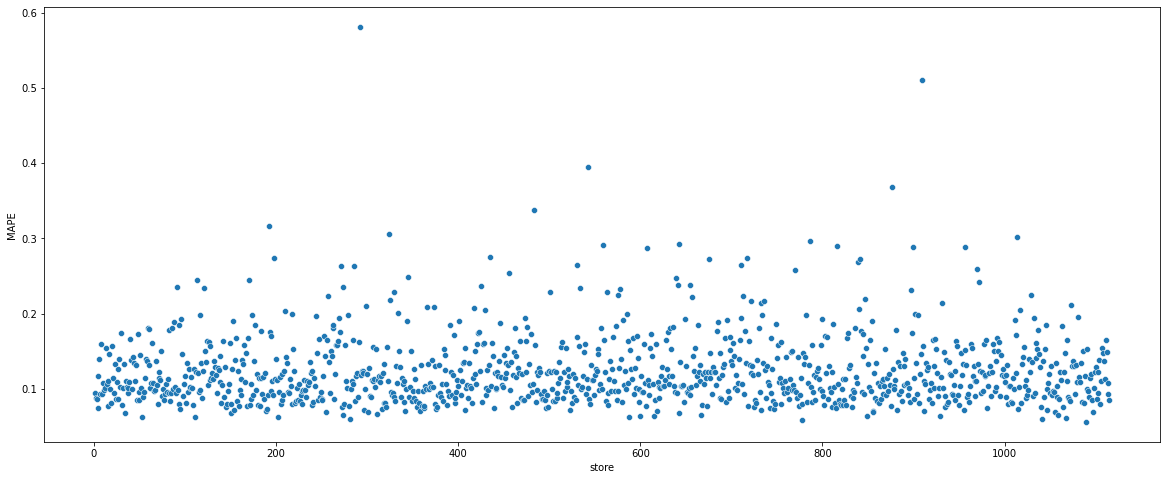

In [107]:
# display store errors in a scatter plot
sns.scatterplot(x='store', y='MAPE', data=df9_final);

We were able to conclude from the plotted graph that most stores have an error around 10%, with some stores getting an error of up to 20% and a small number of stores with errors greater than 20%.

## **Total Performance**

In [108]:
# Summarize the total of predictions, best and worst results that can be obtained
df9_total_performance = df9_final[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenarios', 0: 'Values'})
df9_total_performance['Values'] = df9_total_performance['Values'].map('R${:,.2f}'.format)
df9_total_performance

,Scenarios,Values
0,predictions,"R$287,990,144.00"
1,worst_scenario,"R$253,146,590.20"
2,best_scenario,"R$322,833,728.12"


By summing the total predictions and the best and worst scenarios, we arrive at the plotted values ​​referring to the average percentage error of 12%.

## **Machine Learning Performance**

In [109]:
# create 2 columns to view error and error rate
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

C:\Users\victo\AppData\Local\Temp/ipykernel_107852/2578043693.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales'] - df9['predictions']
C:\Users\victo\AppData\Local\Temp/ipykernel_107852/2578043693.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['predictions'] / df9['sales']


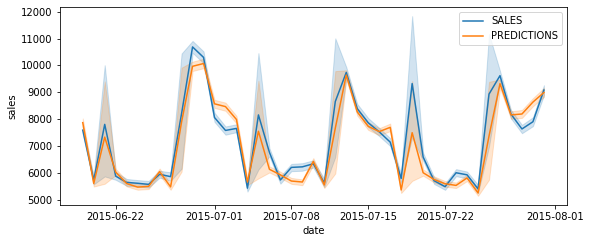

In [110]:
# plot the difference between sales and predictions per day
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' );
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' );

We can analyze that the average sales predictions within the 6 weeks of testing were very close to the actual sales, with the shadows being the variance.

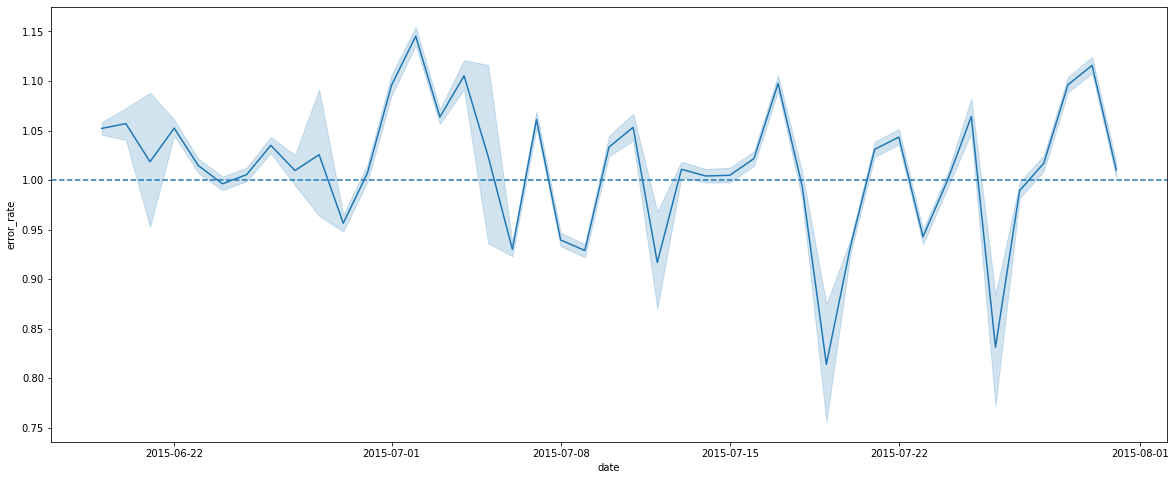

In [111]:
# plot the error rate per day
sns.lineplot( x='date', y='error_rate', data=df9 );
plt.axhline( 1, linestyle='--');

The error rate being 1 shows us a 100% equal relationship of the prediction with the actual sales value for the day. Being above 1 it shows us an overestimation of the predictions in relation to sales on the day and below 1 it shows us an underestimation of the model for the day.

C:\Users\victo\repos\Sales_Prediction\salesprediction\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


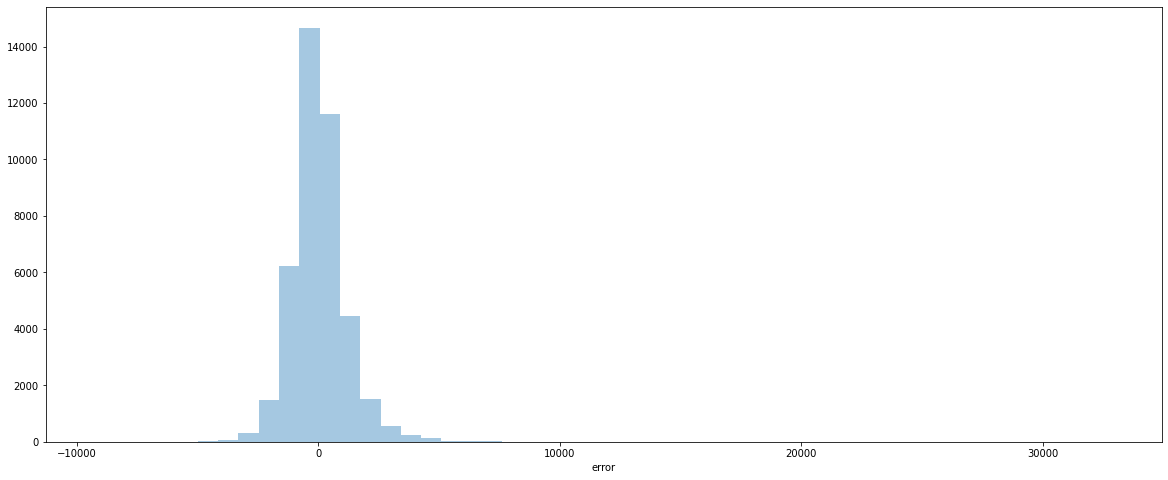

In [112]:
# plot the distribution of errors
sns.distplot(df9['error'], kde=False );

We can conclude that the error distribution is very close to the Gaussian one, which is positive for the model.

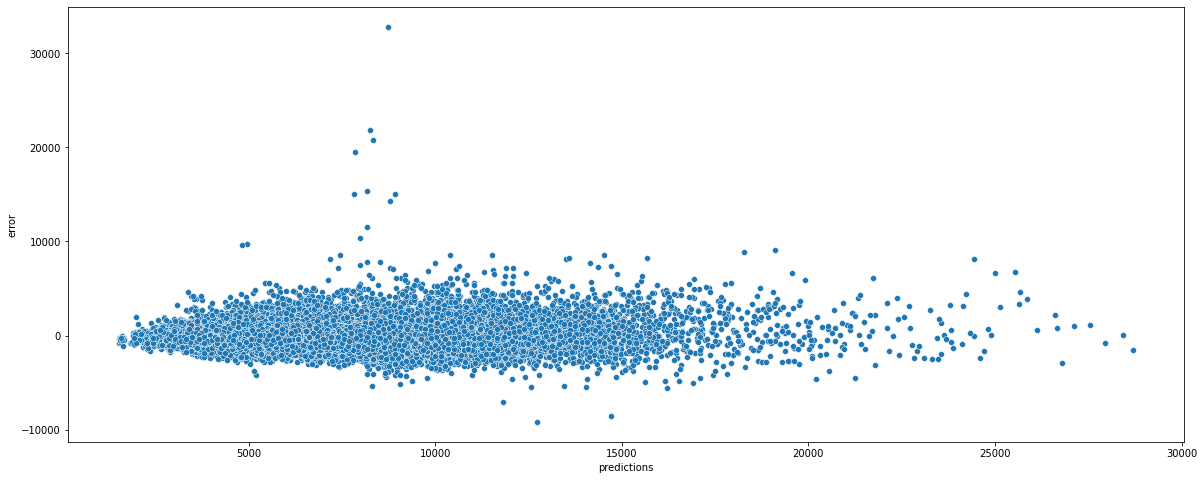

In [113]:
# plot a residual graph
sns.scatterplot( x=df9['predictions'], y=df9['error'] );

In this plot, we can see that the biggest errors are between 5 thousand and 10 thousand, but they are insignificant given the size of the data. In general the dispersion of the residues follows the same along the x axis, which is positive for the model.